## Import Libraries

In [34]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from dateutil import parser
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import matplotlib.image as mpimg
from geopy.distance import vincenty
from collections import Counter
from eli5.sklearn import PermutationImportance
import eli5
from tqdm import tqdm
tqdm.pandas()
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats
from skopt.space import Real
from nltk.sentiment.vader import SentimentIntensityAnalyzer
%matplotlib inline
import seaborn as sns

# Change pandas viewing options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## Download Dataset

In [35]:
# # Seattle data:
# ! wget -xq http://data.insideairbnb.com/united-states/wa/seattle/2018-08-16/data/listings.csv.gz
# ! wget -xq http://data.insideairbnb.com/united-states/wa/seattle/2018-08-16/data/reviews.csv.gz
# # Boston data:
# ! wget -xq http://data.insideairbnb.com/united-states/ma/boston/2018-08-17/data/listings.csv.gz
# ! wget -xq http://data.insideairbnb.com/united-states/ma/boston/2018-08-17/data/reviews.csv.gz
# # Copenhagen data:
# ! wget -xq http://data.insideairbnb.com/denmark/hovedstaden/copenhagen/2018-08-21/data/listings.csv.gz
# ! wget -xq http://data.insideairbnb.com/denmark/hovedstaden/copenhagen/2018-08-21/data/reviews.csv.gz

# ! mv data.insideairbnb.com/united-states/wa/seattle/2018-08-16/data/reviews.csv.gz ../input/reviews_seattle.csv.gz
# ! mv data.insideairbnb.com/united-states/wa/seattle/2018-08-16/data/listings.csv.gz ../input/listings_seattle.csv.gz
# ! mv data.insideairbnb.com/united-states/ma/boston/2018-08-17/data/reviews.csv.gz ../input/reviews_boston.csv.gz
# ! mv data.insideairbnb.com/united-states/ma/boston/2018-08-17/data/listings.csv.gz ../input/listings_boston.csv.gz
# ! mv data.insideairbnb.com/denmark/hovedstaden/copenhagen/2018-08-21/data/reviews.csv.gz ../input/reviews_copenhagen.csv.gz
# ! mv data.insideairbnb.com/denmark/hovedstaden/copenhagen/2018-08-21/data/listings.csv.gz ../input/listings_copenhagen.csv.gz

# ! gunzip ../input/*.gz

In [36]:
seattle_reviews = pd.read_csv('../input/reviews_seattle.csv')
seattle_listings = pd.read_csv('../input/listings_seattle.csv')

# boston_reviews = pd.read_csv('../input/reviews_boston.csv')
# boston_listings = pd.read_csv('../input/listings_boston.csv')

# copenhagen_reviews = pd.read_csv('../input/reviews_copenhagen.csv')
# copenhagen_listings = pd.read_csv('../input/listings_copenhagen.csv')

In [37]:
# seattle_reviews.shape, boston_reviews.shape, copenhagen_reviews.shape
seattle_reviews.shape

(408885, 6)

In [38]:
seattle_reviews.info(max_cols=20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 408885 entries, 0 to 408884
Data columns (total 6 columns):
listing_id       408885 non-null int64
id               408885 non-null int64
date             408885 non-null object
reviewer_id      408885 non-null int64
reviewer_name    408885 non-null object
comments         408697 non-null object
dtypes: int64(3), object(3)
memory usage: 18.7+ MB


In [39]:
seattle_reviews.sample(10, random_state=42) # note that 42 is the answer for everything :-)

listing_id         id        date  reviewer_id reviewer_name                                           comments
270766    18768310  185080419  2017-08-20      5855263         Heidi  Cute little apartment with everything we neede...
378335    30713728  532932322  2019-09-20     40527199        Salaam  Great place in a great location. Would love to...
153906     9054035  437544163  2019-04-14     89675345         Mihir  Great Stay! Close to UW and Gasworks (4 minute...
141722     8017832  106895578  2016-10-08     43390446       Rebecca  Honestly the most comfortable place, it's was ...
336534    24132332  562342894  2019-11-10    279722157   Inderajeeth  The location was great. Quiet neighborhood whi...
135068     7665415  135669865  2017-03-05       361171      Margaret  Great location. Restaurants, bars, coffee shop...
140247     7886645  275802288  2018-06-11     10691819       Zachary  We had a great visit at Kelsey's suite! She wa...
342114    24760583  268345808  2018-05-24     58826133         Ellie                   Good location for Amazon offices
355963    26448460  284565019  2018-07-01    157098655        Daniel  It is a very  nice area the house is beautiful...
155804     9138923   57332294  2015-12-24      7362895       Allyson  What a fantastic place to stay! Anne was incre...

In [40]:
seattle_reviews.columns

Index(['listing_id', 'id', 'date', 'reviewer_id', 'reviewer_name', 'comments'], dtype='object')

In [41]:
seattle_listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'experiences_offered', 'neighborhood_overview',
       ...
       'instant_bookable', 'is_business_travel_ready', 'cancellation_policy', 'require_guest_profile_picture', 'require_guest_phone_verification', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'reviews_per_month'], dtype='object', length=106)

In [42]:
seattle_listings.head()

id                        listing_url       scrape_id last_scraped                                               name                                            summary                                              space                                        description experiences_offered                              neighborhood_overview                                              notes                                            transit                                             access                                        interaction                                        house_rules  thumbnail_url  medium_url                                        picture_url  xl_picture_url  host_id                                 host_url  host_name  host_since                       host_location                                         host_about  host_response_time host_response_rate host_acceptance_rate host_is_superhost                                 host_thumbnail_url  \
0  2318  https://www.airbnb.com/rooms/2318  20200317213002   2020-03-17  Casa Madrona - Urban Oasis 1 block from the park!  Gorgeous, architect remodeled, Dutch Colonial ...  This beautiful, gracious home has been complet...  Gorgeous, architect remodeled, Dutch Colonial ...                none  Madrona is a hidden gem of a neighborhood. It ...  We adhere to a 10pm -9am quiet hour schedule, ...                                                NaN           Guests can access any part of the house.  We are a family who live next door and are ava...                                                NaN            NaN         NaN  https://a0.muscache.com/im/pictures/02973ad3-a...             NaN     2536   https://www.airbnb.com/users/show/2536      Megan  2008-08-26  Seattle, Washington, United States  I welcome guests from all walks of life and ev...      within an hour               100%                  91%                 t  https://a0.muscache.com/im/pictures/user/016a1...   
1  6606  https://www.airbnb.com/rooms/6606  20200317213002   2020-03-18                Fab, private seattle urban cottage!  This tiny cottage is only 15x10, but it has ev...  Soo centrally located, this is a little house ...  This tiny cottage is only 15x10, but it has ev...                none  A peaceful yet highly accessible neighborhood,...  Check in is at three, if you'd like a snack or...                                                NaN                                                NaN  I often escape to kingston and my place on the...  Please treat the cottage as if it were your ow...            NaN         NaN  https://a0.muscache.com/im/pictures/45742/2111...             NaN    14942  https://www.airbnb.com/users/show/14942      Joyce  2009-04-26  Seattle, Washington, United States  I am a therapist/innkeeper.I know my city well...        within a day                90%                  94%                 f  https://a0.muscache.com/im/users/14942/profile...   
2  9419  https://www.airbnb.com/rooms/9419  20200317213002   2020-03-18                Glorious sun room w/ memory foambed  This beautiful double room features a magical ...  Our new Sunny space has a private room from th...  This beautiful double room features a magical ...                none  Lots of restaurants (see our guide book) bars,...  This area is an arts district,you will see all...  Car 2 go is in this neigborhood Bus is across ...  24 /7 access kitchen, bathroom and community s...  I have a hands on warm approach to guests but ...  No drugs,no smoking inside *outside in front o...            NaN         NaN  https://a0.muscache.com/im/pictures/56645186/e...             NaN    30559  https://www.airbnb.com/users/show/30559  Angielena  2009-08-09  Seattle, Washington, United States  I am a visual artist who is  the  director of ...  within a few hours                96%                  92%                 t  https://a0.muscache.com/im/users/30559/profile...   
3  9460  https://www.airbnb.com/rooms/9460  202003172

In [43]:
seattle_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7505 entries, 0 to 7504
Columns: 106 entries, id to reviews_per_month
dtypes: float64(19), int64(23), object(64)
memory usage: 6.1+ MB


## Data Cleaning

### Drop Columns

First, we look the columns with zero non-null values:

In [44]:
unique_nums = seattle_listings.nunique()
masked_columns = [col for col in seattle_listings.columns if unique_nums[col] == 0]
print(masked_columns)
seattle_listings.head(2)

['thumbnail_url', 'medium_url', 'xl_picture_url']


id                        listing_url       scrape_id last_scraped                                               name                                            summary                                              space                                        description experiences_offered                              neighborhood_overview                                              notes transit                                    access                                        interaction                                        house_rules  thumbnail_url  medium_url                                        picture_url  xl_picture_url  host_id                                 host_url host_name  host_since                       host_location                                         host_about host_response_time host_response_rate host_acceptance_rate host_is_superhost                                 host_thumbnail_url                                   host_picture_url  \
0  2318  https://www.airbnb.com/rooms/2318  20200317213002   2020-03-17  Casa Madrona - Urban Oasis 1 block from the park!  Gorgeous, architect remodeled, Dutch Colonial ...  This beautiful, gracious home has been complet...  Gorgeous, architect remodeled, Dutch Colonial ...                none  Madrona is a hidden gem of a neighborhood. It ...  We adhere to a 10pm -9am quiet hour schedule, ...     NaN  Guests can access any part of the house.  We are a family who live next door and are ava...                                                NaN            NaN         NaN  https://a0.muscache.com/im/pictures/02973ad3-a...             NaN     2536   https://www.airbnb.com/users/show/2536     Megan  2008-08-26  Seattle, Washington, United States  I welcome guests from all walks of life and ev...     within an hour               100%                  91%                 t  https://a0.muscache.com/im/pictures/user/016a1...  https://a0.muscache.com/im/pictures/user/016a1...   
1  6606  https://www.airbnb.com/rooms/6606  20200317213002   2020-03-18                Fab, private seattle urban cottage!  This tiny cottage is only 15x10, but it has ev...  Soo centrally located, this is a little house ...  This tiny cottage is only 15x10, but it has ev...                none  A peaceful yet highly accessible neighborhood,...  Check in is at three, if you'd like a snack or...     NaN                                       NaN  I often escape to kingston and my place on the...  Please treat the cottage as if it were your ow...            NaN         NaN  https://a0.muscache.com/im/pictures/45742/2111...             NaN    14942  https://www.airbnb.com/users/show/14942     Joyce  2009-04-26  Seattle, Washington, United States  I am a therapist/innkeeper.I know my city well...       within a day                90%                  94%                 f  https://a0.muscache.com/im/users/14942/profile...  https://a0.muscache.com/im/users/14942/profile...   

  host_neighbourhood  host_listings_count  host_total_listings_count                                 host_verifications host_has_profile_pic host_identity_verified                      street neighbourhood neighbourhood_cleansed neighbourhood_group_cleansed     city state zipcode   market smart_location country_code        country  latitude  longitude is_location_exact property_type        room_type  accommodates  bathrooms  bedrooms  beds  bed_type                                          amenities  square_feet    price weekly_price monthly_price security_deposit cleaning_fee  guests_included extra_people  minimum_nights  maximum_nights  minimum_minimum_nights  maximum_minimum_nights  minimum_maximum_nights  maximum_maximum_nights  minimum_nights_avg_ntm  maximum_nights_avg_ntm calendar_updated has_availability  availability_30  availability_60  availability_90  availability_365 calendar_last_scraped  number_of_reviews  number_of_reviews_ltm first_review last_review  \
0              Minor                    2                       

Column `license`,`id`, `listing_url`, `scrape_id`, `picture_url`, `host_url`, `host_thumbnail_url`, `host_picture_url` is not informative, so I drop it as well:

In [45]:
masked_columns += ['license',
                   'id', 
                   'listing_url', 
                   'scrape_id',
                   'picture_url', 
                   'host_url', 
                   'host_thumbnail_url', 
                   'host_picture_url']

seattle_listings = seattle_listings.drop(masked_columns, axis = 1)
seattle_listings.head(2)

last_scraped                                               name                                            summary                                              space                                        description experiences_offered                              neighborhood_overview                                              notes transit                                    access                                        interaction                                        house_rules  host_id host_name  host_since                       host_location                                         host_about host_response_time host_response_rate host_acceptance_rate host_is_superhost host_neighbourhood  host_listings_count  host_total_listings_count                                 host_verifications host_has_profile_pic host_identity_verified                      street neighbourhood neighbourhood_cleansed neighbourhood_group_cleansed     city state zipcode   market smart_location  \
0   2020-03-17  Casa Madrona - Urban Oasis 1 block from the park!  Gorgeous, architect remodeled, Dutch Colonial ...  This beautiful, gracious home has been complet...  Gorgeous, architect remodeled, Dutch Colonial ...                none  Madrona is a hidden gem of a neighborhood. It ...  We adhere to a 10pm -9am quiet hour schedule, ...     NaN  Guests can access any part of the house.  We are a family who live next door and are ava...                                                NaN     2536     Megan  2008-08-26  Seattle, Washington, United States  I welcome guests from all walks of life and ev...     within an hour               100%                  91%                 t              Minor                    2                          2  ['email', 'phone', 'reviews', 'jumio', 'offlin...                    t                      f  Seattle, WA, United States       Madrona                Madrona                 Central Area  Seattle    WA   98122  Seattle    Seattle, WA   
1   2020-03-18                Fab, private seattle urban cottage!  This tiny cottage is only 15x10, but it has ev...  Soo centrally located, this is a little house ...  This tiny cottage is only 15x10, but it has ev...                none  A peaceful yet highly accessible neighborhood,...  Check in is at three, if you'd like a snack or...     NaN                                       NaN  I often escape to kingston and my place on the...  Please treat the cottage as if it were your ow...    14942     Joyce  2009-04-26  Seattle, Washington, United States  I am a therapist/innkeeper.I know my city well...       within a day                90%                  94%                 f        Wallingford                    5                          5   ['email', 'phone', 'facebook', 'reviews', 'kba']                    t                      t  Seattle, WA, United States   Wallingford            Wallingford          Other neighborhoods  Seattle    WA   98103  Seattle    Seattle, WA   

  country_code        country  latitude  longitude is_location_exact property_type        room_type  accommodates  bathrooms  bedrooms  beds  bed_type                                          amenities  square_feet    price weekly_price monthly_price security_deposit cleaning_fee  guests_included extra_people  minimum_nights  maximum_nights  minimum_minimum_nights  maximum_minimum_nights  minimum_maximum_nights  maximum_maximum_nights  minimum_nights_avg_ntm  maximum_nights_avg_ntm calendar_updated has_availability  availability_30  availability_60  availability_90  availability_365 calendar_last_scraped  number_of_reviews  number_of_reviews_ltm first_review last_review  review_scores_rating  review_scores_accuracy  review_scores_cleanliness  review_scores_checkin  review_scores_communication  review_scores_location  review_scores_value requires_license             jurisdiction_names instant_bookable is_business_travel_ready          cancellation_policy require_guest_profile_picture  \
0           US  Un

First, we will not use textual description columns and datetime columns (except `date_scraped` and `host_since`, which will be used to calculate host experience), it is time to drop them:

In [46]:
textual_datetime_cols = ['name',
                        'summary',
                        'space',
                        'description',
                        'neighborhood_overview',
                        'notes',
                        'transit',
                        'access',
                        'interaction',
                        'host_name',
                        'host_location',
                        'host_about',
                        'host_neighbourhood',
                        'street',
                        'neighbourhood',
                        'state',
                        'zipcode',
                        'market',
                        'smart_location',
                        'city',
                        'country_code',
                        'country', 
                        'calendar_updated', 
                        'calendar_last_scraped', 
                        'first_review',
                        'last_review', 
                        'jurisdiction_names',
                        'experiences_offered']

seattle_listings.drop(textual_datetime_cols, axis=1, inplace=True)
seattle_listings.head(2)

last_scraped                                        house_rules  host_id  host_since host_response_time host_response_rate host_acceptance_rate host_is_superhost  host_listings_count  host_total_listings_count                                 host_verifications host_has_profile_pic host_identity_verified neighbourhood_cleansed neighbourhood_group_cleansed  latitude  longitude is_location_exact property_type        room_type  accommodates  bathrooms  bedrooms  beds  bed_type                                          amenities  square_feet    price weekly_price monthly_price security_deposit cleaning_fee  guests_included extra_people  minimum_nights  maximum_nights  minimum_minimum_nights  maximum_minimum_nights  minimum_maximum_nights  maximum_maximum_nights  minimum_nights_avg_ntm  maximum_nights_avg_ntm has_availability  availability_30  availability_60  availability_90  availability_365  number_of_reviews  number_of_reviews_ltm  review_scores_rating  review_scores_accuracy  \
0   2020-03-17                                                NaN     2536  2008-08-26     within an hour               100%                  91%                 t                    2                          2  ['email', 'phone', 'reviews', 'jumio', 'offlin...                    t                      f                Madrona                 Central Area  47.61082 -122.29082                 t         House  Entire home/apt             9        2.5       4.0   4.0  Real Bed  {Internet,Wifi,Kitchen,"Free parking on premis...          NaN  $296.00          NaN           NaN          $500.00      $250.00                8       $25.00               7            1000                       7                       7                    1125                    1125                     7.0                  1125.0                t               26               56               86                86                 32                     10                 100.0                    10.0   
1   2020-03-18  Please treat the cottage as if it were your ow...    14942  2009-04-26       within a day                90%                  94%                 f                    5                          5   ['email', 'phone', 'facebook', 'reviews', 'kba']                    t                      t            Wallingford          Other neighborhoods  47.65411 -122.33761                 t    Guesthouse  Entire home/apt             2        1.0       1.0   1.0  Real Bed  {TV,Internet,Wifi,"Air conditioning",Kitchen,"...          NaN   $90.00      $670.00           NaN          $200.00       $40.00                2       $10.00              30            1125                      30                      30                    1125                    1125                    30.0                  1125.0                t                0               16               45                45                150                     15                  92.0                     9.0   

   review_scores_cleanliness  review_scores_checkin  review_scores_communication  review_scores_location  review_scores_value requires_license instant_bookable is_business_travel_ready          cancellation_policy require_guest_profile_picture require_guest_phone_verification  calculated_host_listings_count  calculated_host_listings_count_entire_homes  calculated_host_listings_count_private_rooms  calculated_host_listings_count_shared_rooms  reviews_per_month  
0                       10.0                   10.0                         10.0                    10.0                 10.0                t                t                        f  strict_14_with_grace_period                             f                                f                               2                                            2                                             0                                            0               0.23  
1                        9.0                   10.0                         10.0          

Then, we simply drop the columns `property_type`, `bed_type` and `cancellation_policy`:

In [47]:
seattle_listings.property_type.unique()
seattle_listings.bed_type.unique()
seattle_listings.cancellation_policy.unique()
seattle_listings.drop(['property_type', 'bed_type', 'cancellation_policy'], axis=1, inplace=True)

### Change column dtype

Some categorical columns need to be converted into numeric. For example, look on price columns, they are categorical because of '$' sign before the total price:

In [48]:
def prices_to_numbers(price_string):
    price_numeric = float(str(price_string).replace(',', '').split('$')[-1])
    return price_numeric

price_cols = ['price', 
              'weekly_price', 
              'monthly_price', 
              'security_deposit', 
              'cleaning_fee', 
              'extra_people']

for col in price_cols:
    seattle_listings[col] = seattle_listings[col].apply(prices_to_numbers)

seattle_listings.head(2)

last_scraped                                        house_rules  host_id  host_since host_response_time host_response_rate host_acceptance_rate host_is_superhost  host_listings_count  host_total_listings_count                                 host_verifications host_has_profile_pic host_identity_verified neighbourhood_cleansed neighbourhood_group_cleansed  latitude  longitude is_location_exact        room_type  accommodates  bathrooms  bedrooms  beds                                          amenities  square_feet  price  weekly_price  monthly_price  security_deposit  cleaning_fee  guests_included  extra_people  minimum_nights  maximum_nights  minimum_minimum_nights  maximum_minimum_nights  minimum_maximum_nights  maximum_maximum_nights  minimum_nights_avg_ntm  maximum_nights_avg_ntm has_availability  availability_30  availability_60  availability_90  availability_365  number_of_reviews  number_of_reviews_ltm  review_scores_rating  review_scores_accuracy  review_scores_cleanliness  \
0   2020-03-17                                                NaN     2536  2008-08-26     within an hour               100%                  91%                 t                    2                          2  ['email', 'phone', 'reviews', 'jumio', 'offlin...                    t                      f                Madrona                 Central Area  47.61082 -122.29082                 t  Entire home/apt             9        2.5       4.0   4.0  {Internet,Wifi,Kitchen,"Free parking on premis...          NaN  296.0           NaN            NaN             500.0         250.0                8          25.0               7            1000                       7                       7                    1125                    1125                     7.0                  1125.0                t               26               56               86                86                 32                     10                 100.0                    10.0                       10.0   
1   2020-03-18  Please treat the cottage as if it were your ow...    14942  2009-04-26       within a day                90%                  94%                 f                    5                          5   ['email', 'phone', 'facebook', 'reviews', 'kba']                    t                      t            Wallingford          Other neighborhoods  47.65411 -122.33761                 t  Entire home/apt             2        1.0       1.0   1.0  {TV,Internet,Wifi,"Air conditioning",Kitchen,"...          NaN   90.0         670.0            NaN             200.0          40.0                2          10.0              30            1125                      30                      30                    1125                    1125                    30.0                  1125.0                t                0               16               45                45                150                     15                  92.0                     9.0                        9.0   

   review_scores_checkin  review_scores_communication  review_scores_location  review_scores_value requires_license instant_bookable is_business_travel_ready require_guest_profile_picture require_guest_phone_verification  calculated_host_listings_count  calculated_host_listings_count_entire_homes  calculated_host_listings_count_private_rooms  calculated_host_listings_count_shared_rooms  reviews_per_month  
0                   10.0                         10.0                    10.0                 10.0                t                t                        f                             f                                f                               2                                            2                                             0                                            0               0.23  
1                   10.0                         10.0                    10.0                  9.0                t                f                        f                           

Also, some of the categorical columns are in fact Boolean and require conversion:

In [49]:
boolean_cols = ['host_is_superhost', 
               'host_has_profile_pic',
               'host_identity_verified',
               'is_location_exact',
               'has_availability',
               'requires_license',
               'instant_bookable',
               'is_business_travel_ready',
               'require_guest_profile_picture',
               'require_guest_phone_verification']

def booleans_to_numbers(s):
    if s == 'f':
        return 0
    elif s == 't':
        return 1
    return None

for col in boolean_cols:
    seattle_listings[col] = seattle_listings[col].apply(booleans_to_numbers)

Then, we look on individual features for more details.

For example, `host_response_time` is ordinal (ordered categorical) feature, it makes sence to transform it to integers:

In [50]:
seattle_listings.host_response_time.unique()
host_response_dict = {'within an hour': 1, 
                      'within a few hours': 2, 
                      'within a day': 3,
                     'a few days or more': 4}

seattle_listings.host_response_time.replace(host_response_dict, inplace=True)

### Add additional features

Next, we are interested to write the difference between features `last_scraped` and `host_since` into a new feature, `host_experience`, and drop the initial features:

In [51]:
seattle_listings.last_scraped.head(2).values
seattle_listings.dropna(axis=0, how='any', subset=['host_since'], inplace=True)
seattle_listings['host_experience'] = seattle_listings.last_scraped.apply(lambda s: parser.parse(s)) - seattle_listings.host_since.apply(lambda s: parser.parse(s))
seattle_listings.host_experience = seattle_listings.host_experience.astype(str).apply(lambda s: int(s.split(' ')[0]))
seattle_listings.drop(['last_scraped', 'host_since'], axis=1, inplace=True)
seattle_listings.describe().T

count          mean           std         min           25%           50%           75%           max
host_id                                       7505.0  6.981672e+07  8.325966e+07  2536.00000  8.534462e+06  3.369221e+07  9.939316e+07  3.410476e+08
host_response_time                            6003.0  1.239047e+00  5.824215e-01     1.00000  1.000000e+00  1.000000e+00  1.000000e+00  4.000000e+00
host_is_superhost                             7505.0  4.485010e-01  4.973739e-01     0.00000  0.000000e+00  0.000000e+00  1.000000e+00  1.000000e+00
host_listings_count                           7505.0  1.895267e+02  5.464721e+02     0.00000  1.000000e+00  2.000000e+00  1.100000e+01  2.354000e+03
host_total_listings_count                     7505.0  1.895267e+02  5.464721e+02     0.00000  1.000000e+00  2.000000e+00  1.100000e+01  2.354000e+03
host_has_profile_pic                          7505.0  9.994670e-01  2.308170e-02     0.00000  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00
host_identity_verified                        7505.0  5.352432e-01  4.987896e-01     0.00000  0.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00
latitude                                      7505.0  4.762489e+01  4.634380e-02    47.49384  4.760355e+01  4.762068e+01  4.765969e+01  4.773403e+01
longitude                                     7505.0 -1.223335e+02  3.209449e-02  -122.41925 -1.223540e+02 -1.223325e+02 -1.223113e+02 -1.222362e+02
is_location_exact                             7505.0  8.543638e-01  3.527647e-01     0.00000  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00
accommodates                                  7505.0  3.708861e+00  2.329439e+00     1.00000  2.000000e+00  3.000000e+00  4.000000e+00  2.500000e+01
bathrooms                                     7504.0  1.318563e+00  6.663225e-01     0.00000  1.000000e+00  1.000000e+00  1.500000e+00  1.600000e+01
bedrooms                                      7499.0  1.411388e+00  1.015213e+00     0.00000  1.000000e+00  1.000000e+00  2.000000e+00  8.000000e+00
beds                                          7487.0  1.897155e+00  1.496760e+00     0.00000  1.000000e+00  1.000000e+00  2.000000e+00  4.900000e+01
square_feet                                    316.0  6.903418e+02  3.322734e+02     0.00000  6.000000e+02  6.000000e+02  8.500000e+02  2.750000e+03
price                                         7505.0  1.651659e+02  2.759607e+02     0.00000  8.000000e+01  1.200000e+02  1.870000e+02  1.000000e+04
weekly_price                                   840.0  7.937024e+02  6.096165e+02   150.00000  4.685000e+02  6.500000e+02  9.462500e+02  9.100000e+03
monthly_price                                  668.0  2.533154e+03  2.118640e+03   500.00000  1.500000e+03  2.145000e+03  3.000000e+03  3.600000e+04
security_deposit                              6350.0  2.614676e+02  4.069855e+02     0.00000  0.000000e+00  2.000000e+02  4.000000e+02  5.000000e+03
cleaning_fee                                  6995.0  8.608192e+01  7.606940e+01     0.00000  4.000000e+01  6.500000e+01  1.000000e+02  7.000000e+02
guests_included                               7505.0  2.005730e+00  1.658503e+00     1.00000  1.000000e+00  1.000000e+00  2.000000e+00  1.600000e+01
extra_people                                  7505.0  1.238361e+01  2.059562e+01     0.00000  0.000000e+00  5.000000e+00  2.000000e+01  3.000000e+02
minimum_nights                                7505.0  1.288408e+01  2.193673e+01     1.00000  1.000000e+00  2.000000e+00  3.000000e+01  1.000000e+03
maximum_nights                                7505.0  6.365590e+02  5.372614e+02     2.00000  3.000000e+01  1.125000e+03  1.125000e+03  1.000000e+04
minimum_minimum_nights                        7505.0  1.235510e+01  2.180884e+01     1.00000  1.000000e+00  2.000000e+00  3.000000e+01  1.000000e+03
maximum_minimum_nights                        7505.0  1.589674e+01  4.691992e+01     1.00000  2.000000e+00  3.000000e+00  3.000000e+01  1.000000e+03
minimum_maximum_nights  

Then, we extract some meaningful information from `house_rules`:

In [52]:
seattle_listings.house_rules.head(10)

0                                                  NaN
1    Please treat the cottage as if it were your ow...
2    No drugs,no smoking inside *outside in front o...
3    Dear Prospective Guest,   There aren’t really ...
4    *The Sweet Orange is a No Smoking house and ga...
5    *The Tangerine Dream is a Non-Smoking house an...
6    Please treat the apartment as if it were your ...
7    You agree to the following terms and condition...
8    no smoking.recycle, do unto others.. treat thi...
9    Consideration for others is the name of the ga...
Name: house_rules, dtype: object

For example, no smoking and no pets are often requied, so it is good to contain special features for such apartments:

In [53]:
def no_smoking(house_rules_txt):
    is_no_smoking = int('no smoking' in str(house_rules_txt).lower() or 'smoking is not allowed' in str(house_rules_txt).lower())
    return is_no_smoking

def no_pets(house_rules_txt):
    is_no_pets = int('no pets' in str(house_rules_txt).lower() or 'no smoking or pets' in str(house_rules_txt).lower())
    return is_no_pets

seattle_listings['house_rules_no_smoking'] = seattle_listings.house_rules.apply(no_smoking)
seattle_listings['house_rules_no_pets'] = seattle_listings.house_rules.apply(no_pets)
seattle_listings.drop(['house_rules'], axis=1, inplace=True)
seattle_listings.head(2)

host_id  host_response_time host_response_rate host_acceptance_rate  host_is_superhost  host_listings_count  host_total_listings_count                                 host_verifications  host_has_profile_pic  host_identity_verified neighbourhood_cleansed neighbourhood_group_cleansed  latitude  longitude  is_location_exact        room_type  accommodates  bathrooms  bedrooms  beds                                          amenities  square_feet  price  weekly_price  monthly_price  security_deposit  cleaning_fee  guests_included  extra_people  minimum_nights  maximum_nights  minimum_minimum_nights  maximum_minimum_nights  minimum_maximum_nights  maximum_maximum_nights  minimum_nights_avg_ntm  maximum_nights_avg_ntm  has_availability  availability_30  availability_60  availability_90  availability_365  number_of_reviews  number_of_reviews_ltm  review_scores_rating  review_scores_accuracy  review_scores_cleanliness  review_scores_checkin  review_scores_communication  \
0     2536                 1.0               100%                  91%                  1                    2                          2  ['email', 'phone', 'reviews', 'jumio', 'offlin...                     1                       0                Madrona                 Central Area  47.61082 -122.29082                  1  Entire home/apt             9        2.5       4.0   4.0  {Internet,Wifi,Kitchen,"Free parking on premis...          NaN  296.0           NaN            NaN             500.0         250.0                8          25.0               7            1000                       7                       7                    1125                    1125                     7.0                  1125.0                 1               26               56               86                86                 32                     10                 100.0                    10.0                       10.0                   10.0                         10.0   
1    14942                 3.0                90%                  94%                  0                    5                          5   ['email', 'phone', 'facebook', 'reviews', 'kba']                     1                       1            Wallingford          Other neighborhoods  47.65411 -122.33761                  1  Entire home/apt             2        1.0       1.0   1.0  {TV,Internet,Wifi,"Air conditioning",Kitchen,"...          NaN   90.0         670.0            NaN             200.0          40.0                2          10.0              30            1125                      30                      30                    1125                    1125                    30.0                  1125.0                 1                0               16               45                45                150                     15                  92.0                     9.0                        9.0                   10.0                         10.0   

   review_scores_location  review_scores_value  requires_license  instant_bookable  is_business_travel_ready  require_guest_profile_picture  require_guest_phone_verification  calculated_host_listings_count  calculated_host_listings_count_entire_homes  calculated_host_listings_count_private_rooms  calculated_host_listings_count_shared_rooms  reviews_per_month  host_experience  house_rules_no_smoking  house_rules_no_pets  
0                    10.0                 10.0                 1                 1                         0                              0                                 0                               2                                            2                                             0                                            0               0.23             4221                       0                    0  
1                    10.0                  9.0                 1                 0                         0                              0                                 0                               3    

It makes sense to count the number of different verifications and to create a new feature, `host_verification_level`:

In [54]:
seattle_listings['host_verification_level'] = seattle_listings.host_verifications.apply(lambda s: len(s.split(', ')))
print(seattle_listings.host_verification_level.describe())
seattle_listings.host_verifications.head(10).values

count    7505.000000
mean        5.855696
std         2.303259
min         1.000000
25%         4.000000
50%         6.000000
75%         7.000000
max        12.000000
Name: host_verification_level, dtype: float64


array(["['email', 'phone', 'reviews', 'jumio', 'offline_government_id', 'selfie', 'government_id', 'identity_manual']",
       "['email', 'phone', 'facebook', 'reviews', 'kba']",
       "['email', 'phone', 'reviews', 'jumio', 'offline_government_id', 'government_id']",
       "['email', 'phone', 'reviews', 'offline_government_id', 'kba', 'selfie', 'government_id']",
       "['email', 'phone', 'reviews', 'kba']",
       "['email', 'phone', 'reviews', 'kba']",
       "['email', 'phone', 'facebook', 'reviews', 'kba']",
       "['email', 'phone', 'reviews', 'jumio', 'offline_government_id', 'selfie', 'government_id', 'identity_manual']",
       "['email', 'phone', 'facebook', 'reviews', 'kba']",
       "['email', 'phone', 'facebook', 'reviews', 'jumio', 'offline_government_id', 'government_id', 'work_email']"],
      dtype=object)

Column `host_response_rate` can be easily converted to numerical `host_response_fraction`:

In [55]:
seattle_listings.host_response_rate.unique()

array(['100%', '90%', '96%', '80%', nan, '89%', '94%', '95%', '74%',
       '85%', '86%', '0%', '88%', '99%', '75%', '98%', '70%', '91%',
       '83%', '30%', '50%', '97%', '81%', '20%', '76%', '67%', '93%',
       '33%', '57%', '25%', '69%', '92%', '82%', '78%', '60%', '43%',
       '40%'], dtype=object)

In [170]:
def rate_to_fraction(rate_str):
    if rate_str == 0:
        rate_frac = None
    else:
        rate_frac = 0.01*int(str(rate_str).split('%')[0])

        return rate_frac
    
seattle_listings['host_response_fraction'] = seattle_listings.host_response_rate.fillna(0).apply(rate_to_fraction)
seattle_listings['host_acceptance_fraction'] = seattle_listings.host_acceptance_rate.fillna(0).apply(rate_to_fraction)
seattle_listings.drop(['host_acceptance_rate'], axis=1, inplace=True)
seattle_listings.drop(['host_response_rate'], axis=1, inplace=True)
seattle_listings.head(2)

city_index  host_id  host_listings_count                                 host_verifications neighbourhood_cleansed neighbourhood_group_cleansed  latitude  longitude  room_type  accommodates  bathrooms  bedrooms  beds  price  security_deposit  cleaning_fee  guests_included  extra_people  availability_365  number_of_reviews  number_of_reviews_ltm  review_scores_rating  review_scores_value  calculated_host_listings_count  calculated_host_listings_count_entire_homes  calculated_host_listings_count_private_rooms  reviews_per_month  host_experience  host_response_fraction  amenities_number  lat_center  lon_center  distance_center  host_acceptance_fraction
0           1     2536                    2  ['email', 'phone', 'reviews', 'jumio', 'offlin...                Madrona                 Central Area  47.61082 -122.29082          3             9        2.5       4.0   4.0  296.0             500.0         250.0                8          25.0                86                 32                     10                 100.0                 10.0                               2                                            2                                             0               0.23             4221                     1.0                39    47.60621  -122.33207         3.143579                      0.91
1           1    14942                    5   ['email', 'phone', 'facebook', 'reviews', 'kba']            Wallingford          Other neighborhoods  47.65411 -122.33761          3             2        1.0       1.0   1.0   90.0             200.0          40.0                2          10.0                45                150                     15                  92.0                  9.0                               3                                            3                                             0               1.15             3979                     0.9                21    47.60621  -122.33207         5.341923                      0.94

In [57]:
seattle_listings.room_type.unique()

array(['Entire home/apt', 'Private room', 'Shared room', 'Hotel room'],
      dtype=object)

In [155]:
room_type_dict = {'Shared room': 1, 'Private room': 2, 'Entire home/apt': 3, 'Hotel room': 4}
seattle_listings.room_type.replace(room_type_dict, inplace=True)

Finally, look on categorical feature `amenities`:

In [59]:
seattle_listings.amenities.head().values

array(['{Internet,Wifi,Kitchen,"Free parking on premises","Pets allowed","Free street parking","Indoor fireplace",Heating,"Family/kid friendly",Washer,Dryer,"Smoke detector","Carbon monoxide detector","First aid kit","Fire extinguisher",Essentials,Shampoo,Hangers,"Hair dryer",Iron,"Laptop friendly workspace","High chair","Children’s books and toys","Pack ’n Play/travel crib","Hot water",Microwave,"Coffee maker",Refrigerator,Dishwasher,"Dishes and silverware","Cooking basics",Oven,Stove,"Patio or balcony","Garden or backyard","Luggage dropoff allowed","Long term stays allowed","Host greets you","Lake access"}',
       '{TV,Internet,Wifi,"Air conditioning",Kitchen,"Free parking on premises",Heating,"Smoke detector","Carbon monoxide detector","Fire extinguisher",Essentials,Shampoo,"24-hour check-in",Hangers,"Hair dryer",Iron,"Laptop friendly workspace","translation missing: en.hosting_amenity_50","Private entrance","Bed linens","Extra pillows and blankets"}',
       '{Internet,Wifi,"Air c

Here, we create three new features, `is_TV`, `is_Wifi` and the number of different amenities `amenities_number`:

In [60]:
seattle_listings['is_TV'] = seattle_listings.amenities.apply(lambda s: int('TV' in str(s)[1:].split(',')))
seattle_listings['is_Wifi'] = seattle_listings.amenities.apply(lambda s: int('Wifi' in str(s)[1:].split(',')))
seattle_listings['amenities_number'] = seattle_listings.amenities.apply(lambda s: len(str(s)[1:].split(',')))

seattle_listings.drop('amenities', axis=1, inplace=True)

## Treatment of missing variables:

In [61]:
seattle_listings.isnull().sum().sort_values(ascending=False).head(20)

square_feet                    7189
monthly_price                  6837
weekly_price                   6665
host_response_time             1502
host_response_fraction         1502
security_deposit               1155
review_scores_accuracy         1040
review_scores_cleanliness      1040
review_scores_checkin          1039
review_scores_location         1039
review_scores_value            1038
review_scores_communication    1038
review_scores_rating           1028
reviews_per_month               984
host_acceptance_rate            892
cleaning_fee                    510
beds                             18
bedrooms                          6
bathrooms                         1
guests_included                   0
dtype: int64

Because columns `bathrooms`, `beds` and `bedrooms` contain very small number of NaNs, we just dropped the corresponding instances:

In [62]:
seattle_listings.dropna(axis=0, how='any', subset=['bathrooms', 'beds', 'bedrooms'], inplace=True)

Next, we fully drop the columns `square_feet`, `monthly_price` and `weekly_price`:

In [63]:
seattle_listings.drop(axis=1, columns=['square_feet', 'monthly_price', 'weekly_price'], inplace=True)

Finally, we drop the duplicate columns `host_total_listings_count` and `is_business_travel_ready`:

In [64]:
seattle_listings_1 = seattle_listings.T.drop_duplicates().T
duplicate_cols = [i for i in seattle_listings.columns if i not in seattle_listings_1.columns]
del seattle_listings_1
seattle_listings.drop(duplicate_cols, axis=1, inplace=True)
seattle_description = seattle_listings.describe().T
seattle_description

count          mean           std         min           25%           50%           75%           max
host_id                                       7482.0  6.947710e+07  8.290887e+07  2536.00000  8.534462e+06  3.352465e+07  9.830162e+07  3.410476e+08
host_response_time                            5981.0  1.239425e+00  5.828002e-01     1.00000  1.000000e+00  1.000000e+00  1.000000e+00  4.000000e+00
host_is_superhost                             7482.0  4.497461e-01  4.975014e-01     0.00000  0.000000e+00  0.000000e+00  1.000000e+00  1.000000e+00
host_listings_count                           7482.0  1.900965e+02  5.472146e+02     0.00000  1.000000e+00  2.000000e+00  1.100000e+01  2.354000e+03
host_has_profile_pic                          7482.0  9.994654e-01  2.311714e-02     0.00000  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00
host_identity_verified                        7482.0  5.362203e-01  4.987197e-01     0.00000  0.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00
latitude                                      7482.0  4.762488e+01  4.635868e-02    47.49384  4.760368e+01  4.762076e+01  4.765969e+01  4.773403e+01
longitude                                     7482.0 -1.223335e+02  3.209628e-02  -122.41925 -1.223541e+02 -1.223325e+02 -1.223115e+02 -1.222362e+02
is_location_exact                             7482.0  8.552526e-01  3.518695e-01     0.00000  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00
accommodates                                  7482.0  3.713713e+00  2.330722e+00     1.00000  2.000000e+00  3.000000e+00  4.000000e+00  2.500000e+01
bathrooms                                     7482.0  1.318431e+00  6.664861e-01     0.00000  1.000000e+00  1.000000e+00  1.500000e+00  1.600000e+01
bedrooms                                      7482.0  1.412056e+00  1.016021e+00     0.00000  1.000000e+00  1.000000e+00  2.000000e+00  8.000000e+00
beds                                          7482.0  1.897487e+00  1.497062e+00     0.00000  1.000000e+00  1.000000e+00  2.000000e+00  4.900000e+01
price                                         7482.0  1.653283e+02  2.761495e+02     0.00000  8.000000e+01  1.200000e+02  1.880000e+02  1.000000e+04
security_deposit                              6332.0  2.615554e+02  4.075049e+02     0.00000  0.000000e+00  2.000000e+02  4.000000e+02  5.000000e+03
cleaning_fee                                  6975.0  8.623484e+01  7.611657e+01     0.00000  4.000000e+01  6.500000e+01  1.000000e+02  7.000000e+02
guests_included                               7482.0  2.008420e+00  1.660235e+00     1.00000  1.000000e+00  1.000000e+00  2.000000e+00  1.600000e+01
extra_people                                  7482.0  1.240029e+01  2.062007e+01     0.00000  0.000000e+00  5.000000e+00  2.000000e+01  3.000000e+02
minimum_nights                                7482.0  1.290404e+01  2.195915e+01     1.00000  1.000000e+00  2.000000e+00  3.000000e+01  1.000000e+03
maximum_nights                                7482.0  6.372451e+02  5.371708e+02     2.00000  3.000000e+01  1.125000e+03  1.125000e+03  1.000000e+04
minimum_minimum_nights                        7482.0  1.237343e+01  2.183146e+01     1.00000  1.000000e+00  2.000000e+00  3.000000e+01  1.000000e+03
maximum_minimum_nights                        7482.0  1.592502e+01  4.698543e+01     1.00000  2.000000e+00  3.000000e+00  3.000000e+01  1.000000e+03
minimum_maximum_nights                        7482.0  7.755487e+02  5.067113e+02     1.00000  9.000000e+01  1.125000e+03  1.125000e+03  1.000000e+04
maximum_maximum_nights                        7482.0  7.782934e+02  5.051768e+02     2.00000  9.000000e+01  1.125000e+03  1.125000e+03  1.000000e+04
minimum_nights_avg_ntm                        7482.0  1.508260e+01  4.538014e+01     1.00000  2.000000e+00  2.800000e+00  3.000000e+01  1.000000e+03
maximum_nights_avg_ntm                        7482.0  7.772758e+02  5.055259e+02     2.00000  9.000000e+01  1.125000e+03  1.125000e+03  1.000000e+04
has_availability        

As we see, feature `requires_license` can be dropped. Also, there are several columns with high-end outliers, such as `maximum_nights`, `minimum_nights` and `price`. Let us drop them automatically with the help of the [interquartile range rule](https://www.thoughtco.com/what-is-the-interquartile-range-rule-3126244):

In [65]:
seattle_description['iqr_max'] = seattle_description['75%'] + 1.5 * (seattle_description['75%'] - seattle_description['25%'])
seattle_description['iqr_min'] = seattle_description['75%'] - 1.5 * (seattle_description['75%'] - seattle_description['25%'])

cols_to_drop_outliers = ['maximum_nights', 'minimum_nights', 'price']

for col in cols_to_drop_outliers:
    print(col)
    seattle_listings = seattle_listings[((seattle_listings[col] > seattle_description.loc[col, 'iqr_min']) & (seattle_listings[col] < seattle_description.loc[col, 'iqr_max']))]

maximum_nights
minimum_nights
price


Finally, we want to add geographical distance from cities to city centers (I take coordinates from [here](http://dateandtime.info/citycoordinates.php))

In [66]:
lat_center_dict = {1: 47.6062100, 2: 42.3584300, 3: 55.675940}
lon_center_dict = {1: -122.3320700, 2: -71.0597700, 3: 12.5655300}

In [67]:
seattle_listings = pd.concat([seattle_listings], keys = [1])
seattle_listings.reset_index(level=0, inplace=True)
seattle_listings.rename(columns={'level_0': 'city_index'}, inplace=True)
seattle_listings['lat_center'] = seattle_listings.city_index.replace(lat_center_dict)
seattle_listings['lon_center'] = seattle_listings.city_index.replace(lon_center_dict)

In [68]:
%%time
# calculates Vincenty distance from the city center using https://en.wikipedia.org/wiki/Vincenty%27s_formulae 
seattle_listings['distance_center'] = seattle_listings.apply(lambda x: vincenty((x['latitude'], x['longitude']), (x['lat_center'], x['lon_center'])).km, axis = 1)

CPU times: user 532 ms, sys: 11.8 ms, total: 544 ms
Wall time: 544 ms


In [69]:
seattle_listings['distance_center'].describe()

count    6880.000000
mean        5.126786
std         3.392213
min         0.090473
25%         1.964999
50%         4.975489
75%         7.722593
max        14.561875
Name: distance_center, dtype: float64

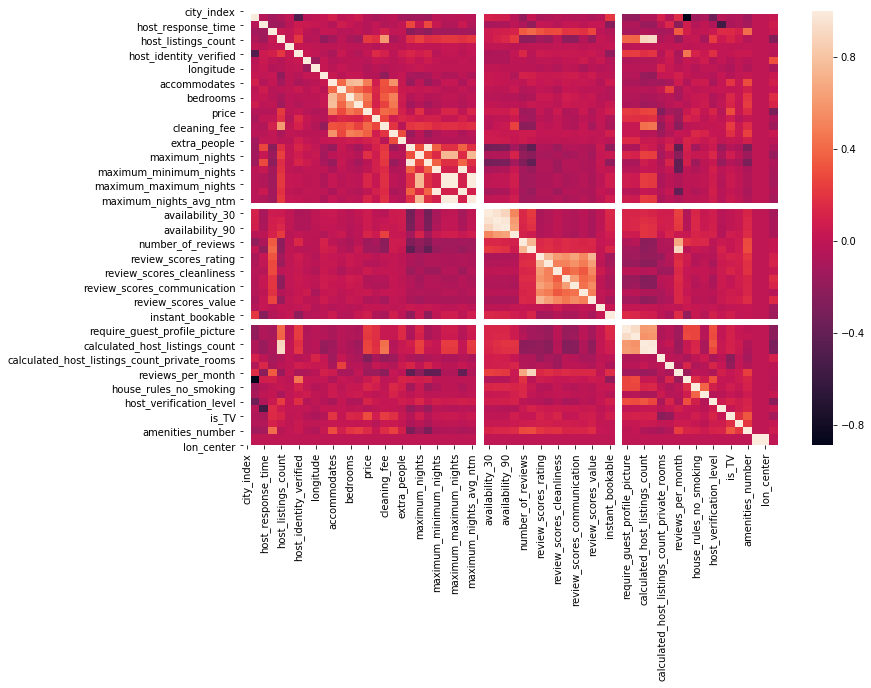

In [70]:
plt.figure(figsize=(12,8))
sns.heatmap(seattle_listings.corr());
plt.show()

In [156]:
# ! rm ../input/cleaned_seattle_listings.pkl
seattle_listings.to_hdf('../input/cleaned_seattle_listings.h5', key='seattle_listings', mode='w')

In [81]:
print(seattle_reviews.columns)
seattle_reviews.head()

Index(['listing_id', 'id', 'date', 'reviewer_id', 'reviewer_name', 'comments'], dtype='object')


listing_id         id        date  reviewer_id reviewer_name                                           comments
0        2318        146  2008-09-15         2451         Kevin        1000 times better than staying at a hotel. 
1        2318  126302712  2017-01-10     12332845       Jessica  Our family (two couples, a two year old and an...
2        2318  140977084  2017-04-01      4789466          Ivan  Top of the list locations we have stayed at! T...
3        2318  147262504  2017-04-25     55817131          Mike  SUCH an awesome place. Very clean, quiet and s...
4        2318  161806368  2017-06-18    113604590          Pete  We flew quite a distance to be at our only dau...

In [82]:
seattle_reviews.comments.isnull().sum()

0

In [83]:
seattle_reviews.dropna(subset=['comments'], how='any', axis=0, inplace=True)
seattle_reviews.comments.isnull().sum()

0

In [84]:
# calculates compound sentiment polarity of the sentence
vader_polarity_compound = lambda s: (SentimentIntensityAnalyzer().polarity_scores(s))['compound']

In [85]:
# import nltk
# nltk.download('vader_lexicon')

In [89]:
%%time
seattle_reviews['polarity'] = seattle_reviews.comments.map(vader_polarity_compound)
seattle_reviews.to_hdf('../input/cleaned_seattle_reviews.h5', key='seattle_reviews', mode='w')

CPU times: user 49min 55s, sys: 15.2 s, total: 50min 10s
Wall time: 50min 11s


## Data Visualization

    1) Visualize your data and search for pattern that can help you solve your problem.
    2) Correlation analysis helps us to see features relatations.

In [154]:
seattle_reviews = pd.read_hdf('../input/cleaned_seattle_reviews.h5', 'seattle_reviews')
seattle_listings = pd.read_hdf('../input/cleaned_seattle_listings.h5', 'seattle_listings')
# seattle_reviews = pd.read_pickle('../input/cleaned_seattle_reviews.pkl')
# seattle_listings = pd.read_pickle('../input/cleaned_seattle_listings.pkl')

In [91]:
seattle_reviews.head()

listing_id         id        date  reviewer_id reviewer_name                                           comments  polarity
0        2318        146  2008-09-15         2451         Kevin        1000 times better than staying at a hotel.     0.4404
1        2318  126302712  2017-01-10     12332845       Jessica  Our family (two couples, a two year old and an...    0.9975
2        2318  140977084  2017-04-01      4789466          Ivan  Top of the list locations we have stayed at! T...    0.9796
3        2318  147262504  2017-04-25     55817131          Mike  SUCH an awesome place. Very clean, quiet and s...    0.9059
4        2318  161806368  2017-06-18    113604590          Pete  We flew quite a distance to be at our only dau...    0.8381

In [92]:
seattle_listings.head()

city_index  host_id  host_response_time host_acceptance_rate  host_is_superhost  host_listings_count                                 host_verifications  host_has_profile_pic  host_identity_verified neighbourhood_cleansed neighbourhood_group_cleansed  latitude  longitude  is_location_exact room_type  accommodates  bathrooms  bedrooms  beds  price  security_deposit  cleaning_fee  guests_included  extra_people  minimum_nights  maximum_nights  minimum_minimum_nights  maximum_minimum_nights  minimum_maximum_nights  maximum_maximum_nights  minimum_nights_avg_ntm  maximum_nights_avg_ntm  has_availability  availability_30  availability_60  availability_90  availability_365  number_of_reviews  number_of_reviews_ltm  review_scores_rating  review_scores_accuracy  review_scores_cleanliness  review_scores_checkin  review_scores_communication  review_scores_location  review_scores_value  requires_license  instant_bookable  is_business_travel_ready  require_guest_profile_picture  \
0           1     2536                 1.0                  91%                  1                    2  ['email', 'phone', 'reviews', 'jumio', 'offlin...                     1                       0                Madrona                 Central Area  47.61082 -122.29082                  1         3             9        2.5       4.0   4.0  296.0             500.0         250.0                8          25.0               7            1000                       7                       7                    1125                    1125                     7.0                  1125.0                 1               26               56               86                86                 32                     10                 100.0                    10.0                       10.0                   10.0                         10.0                    10.0                 10.0                 1                 1                         0                              0   
1           1    14942                 3.0                  94%                  0                    5   ['email', 'phone', 'facebook', 'reviews', 'kba']                     1                       1            Wallingford          Other neighborhoods  47.65411 -122.33761                  1         3             2        1.0       1.0   1.0   90.0             200.0          40.0                2          10.0              30            1125                      30                      30                    1125                    1125                    30.0                  1125.0                 1                0               16               45                45                150                     15                  92.0                     9.0                        9.0                   10.0                         10.0                    10.0                  9.0                 1                 0                         0                              0   
2           1    30559                 2.0                  92%                  1                    8  ['email', 'phone', 'reviews', 'jumio', 'offlin...                     1                       1             Georgetown          Other neighborhoods  47.55017 -122.31937                  1         2             2        3.0       1.0   1.0   62.0             100.0          20.0                1          15.0               2             180                       2                       2                     180                     180                     2.0                   180.0                 1               30               60               90               365                148                     16                  93.0                    10.0                       10.0                   10.0                         10.0                    10.0                 10.0                 1                 0                         0                              1   
3           1    30832                 1.0                 100%

Get correlation between different features

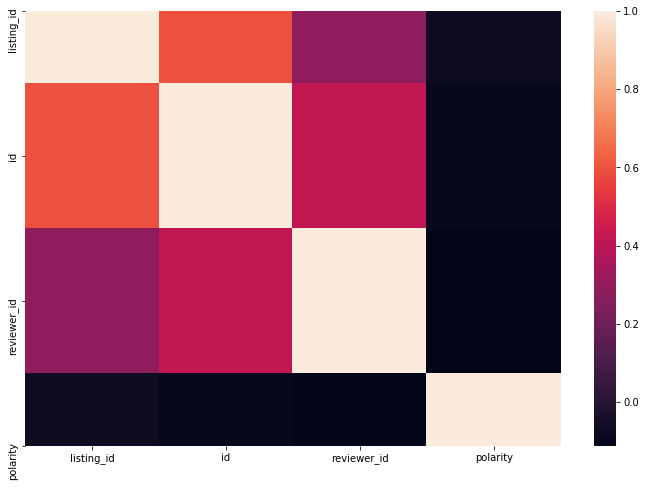

In [93]:
plt.figure(figsize=(12,8))
sns.heatmap(seattle_reviews.corr());
plt.show()

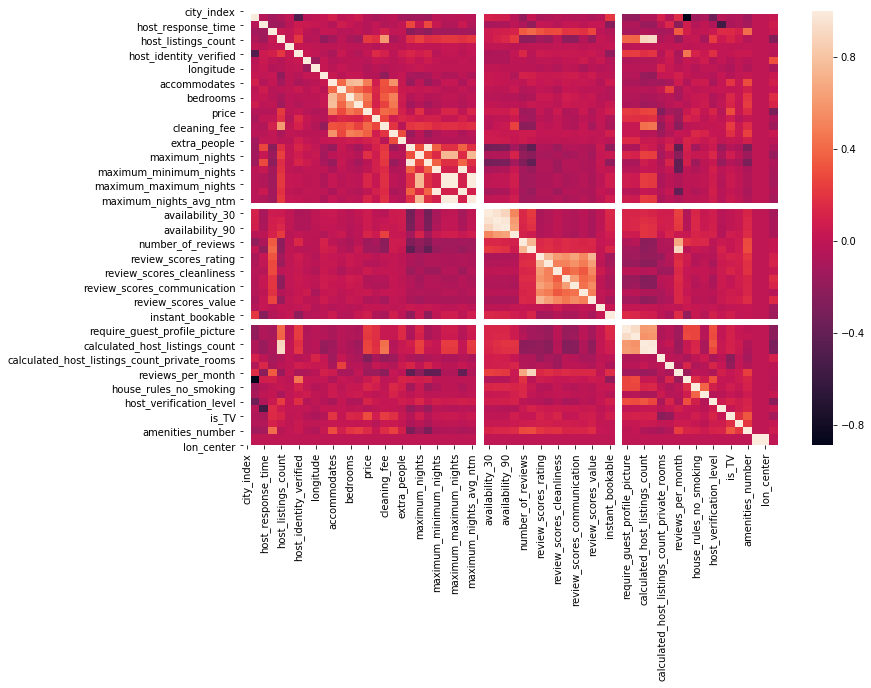

In [94]:
plt.figure(figsize=(12,8))
sns.heatmap(seattle_listings.corr());
plt.show()

Visualizing the distribution for every `feature`

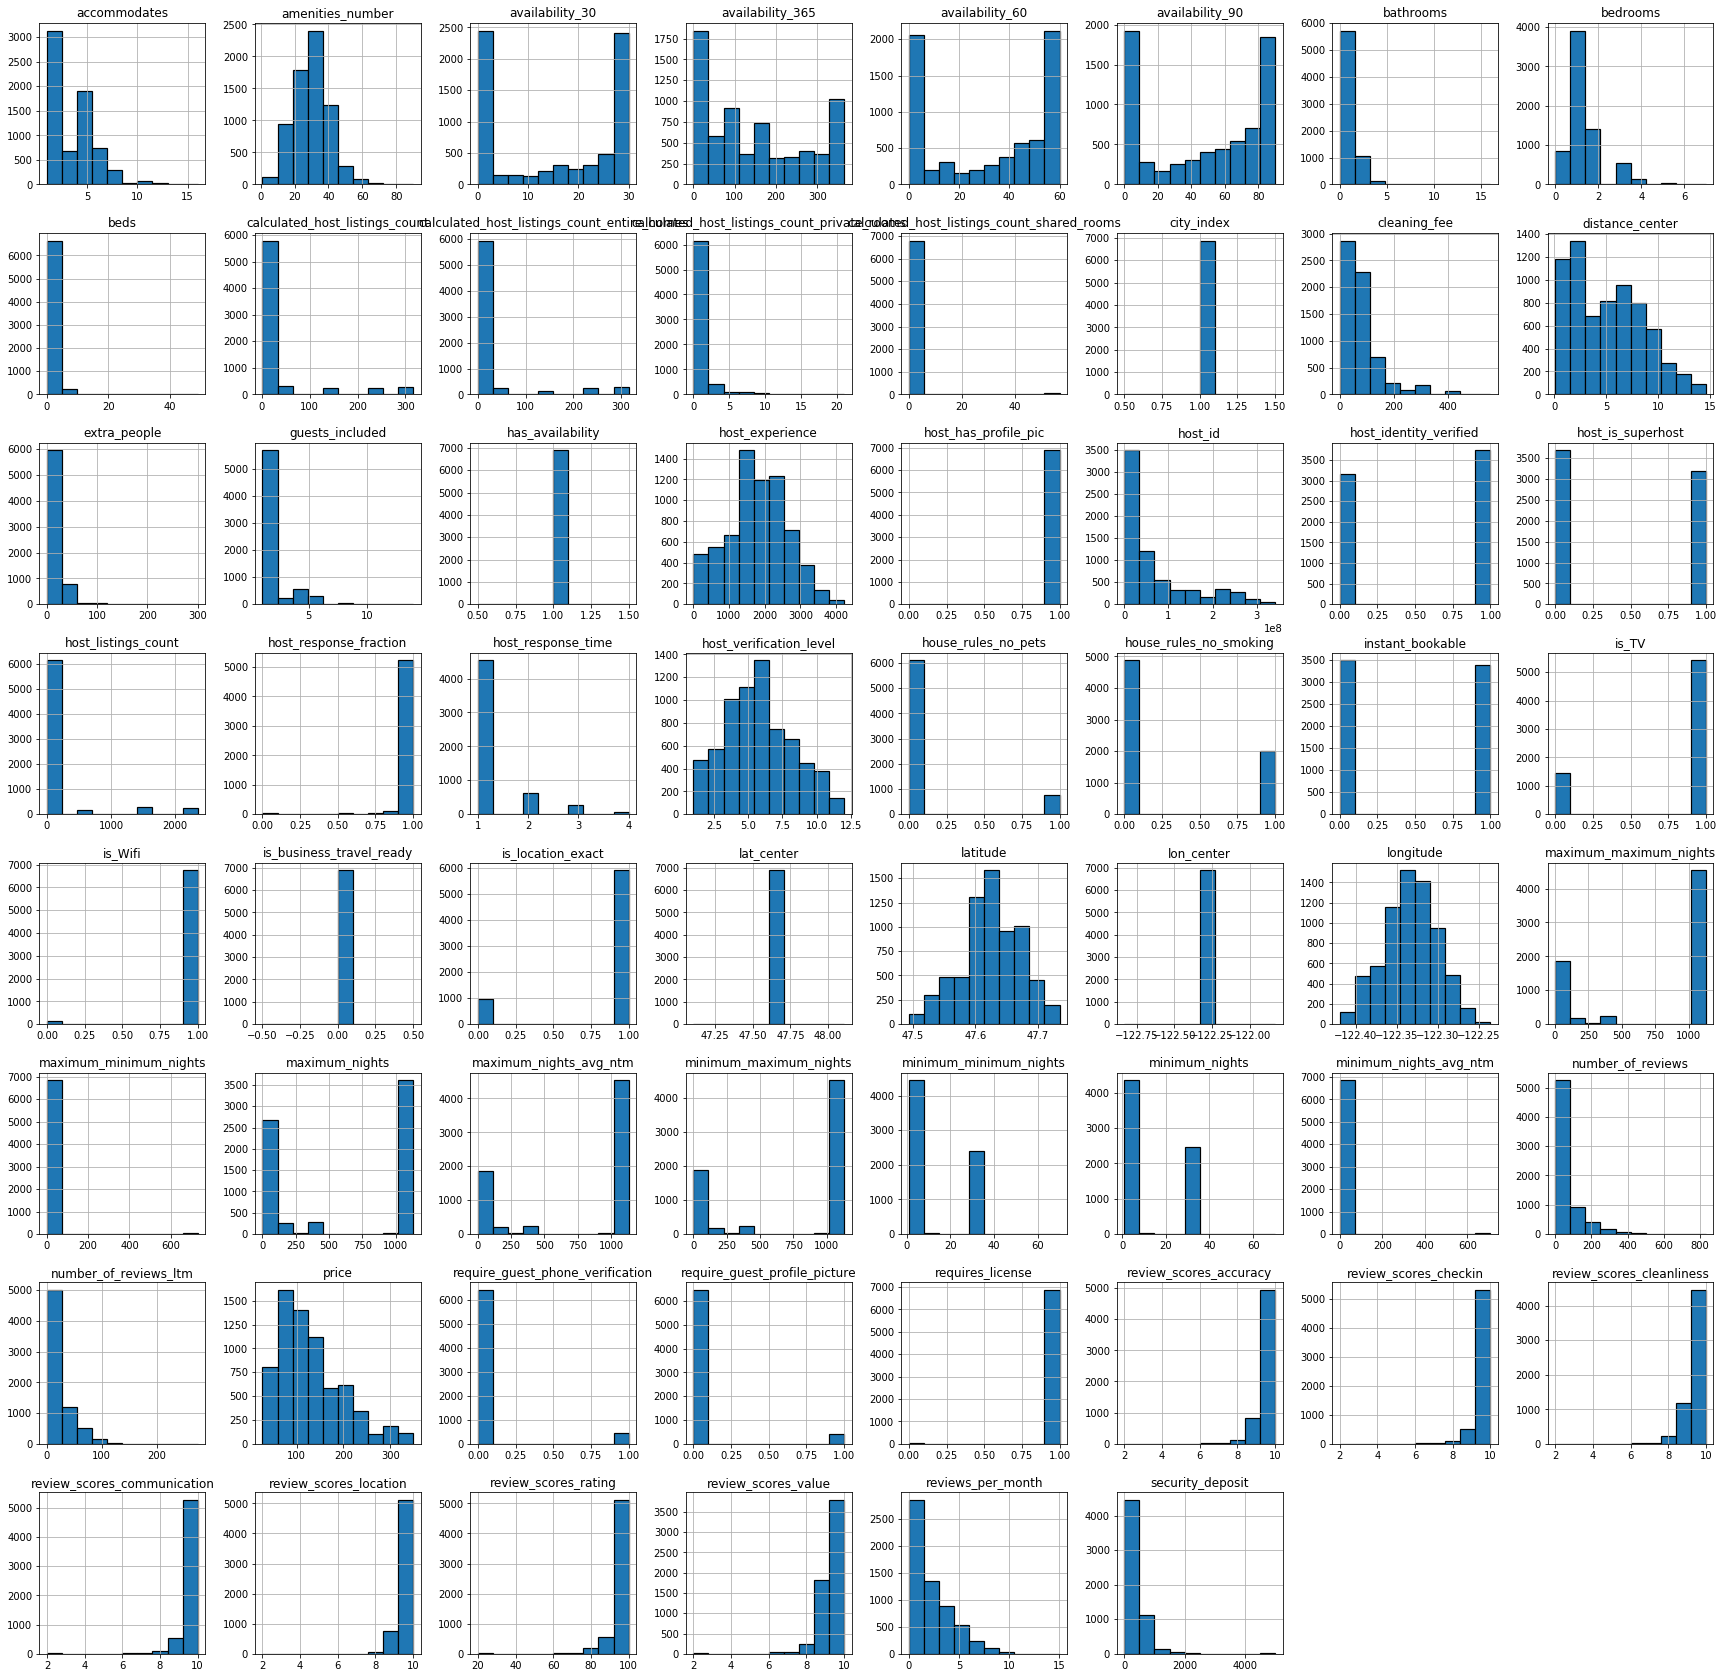

In [95]:
seattle_listings.hist(edgecolor="black", linewidth=1.2, figsize=(30, 30));

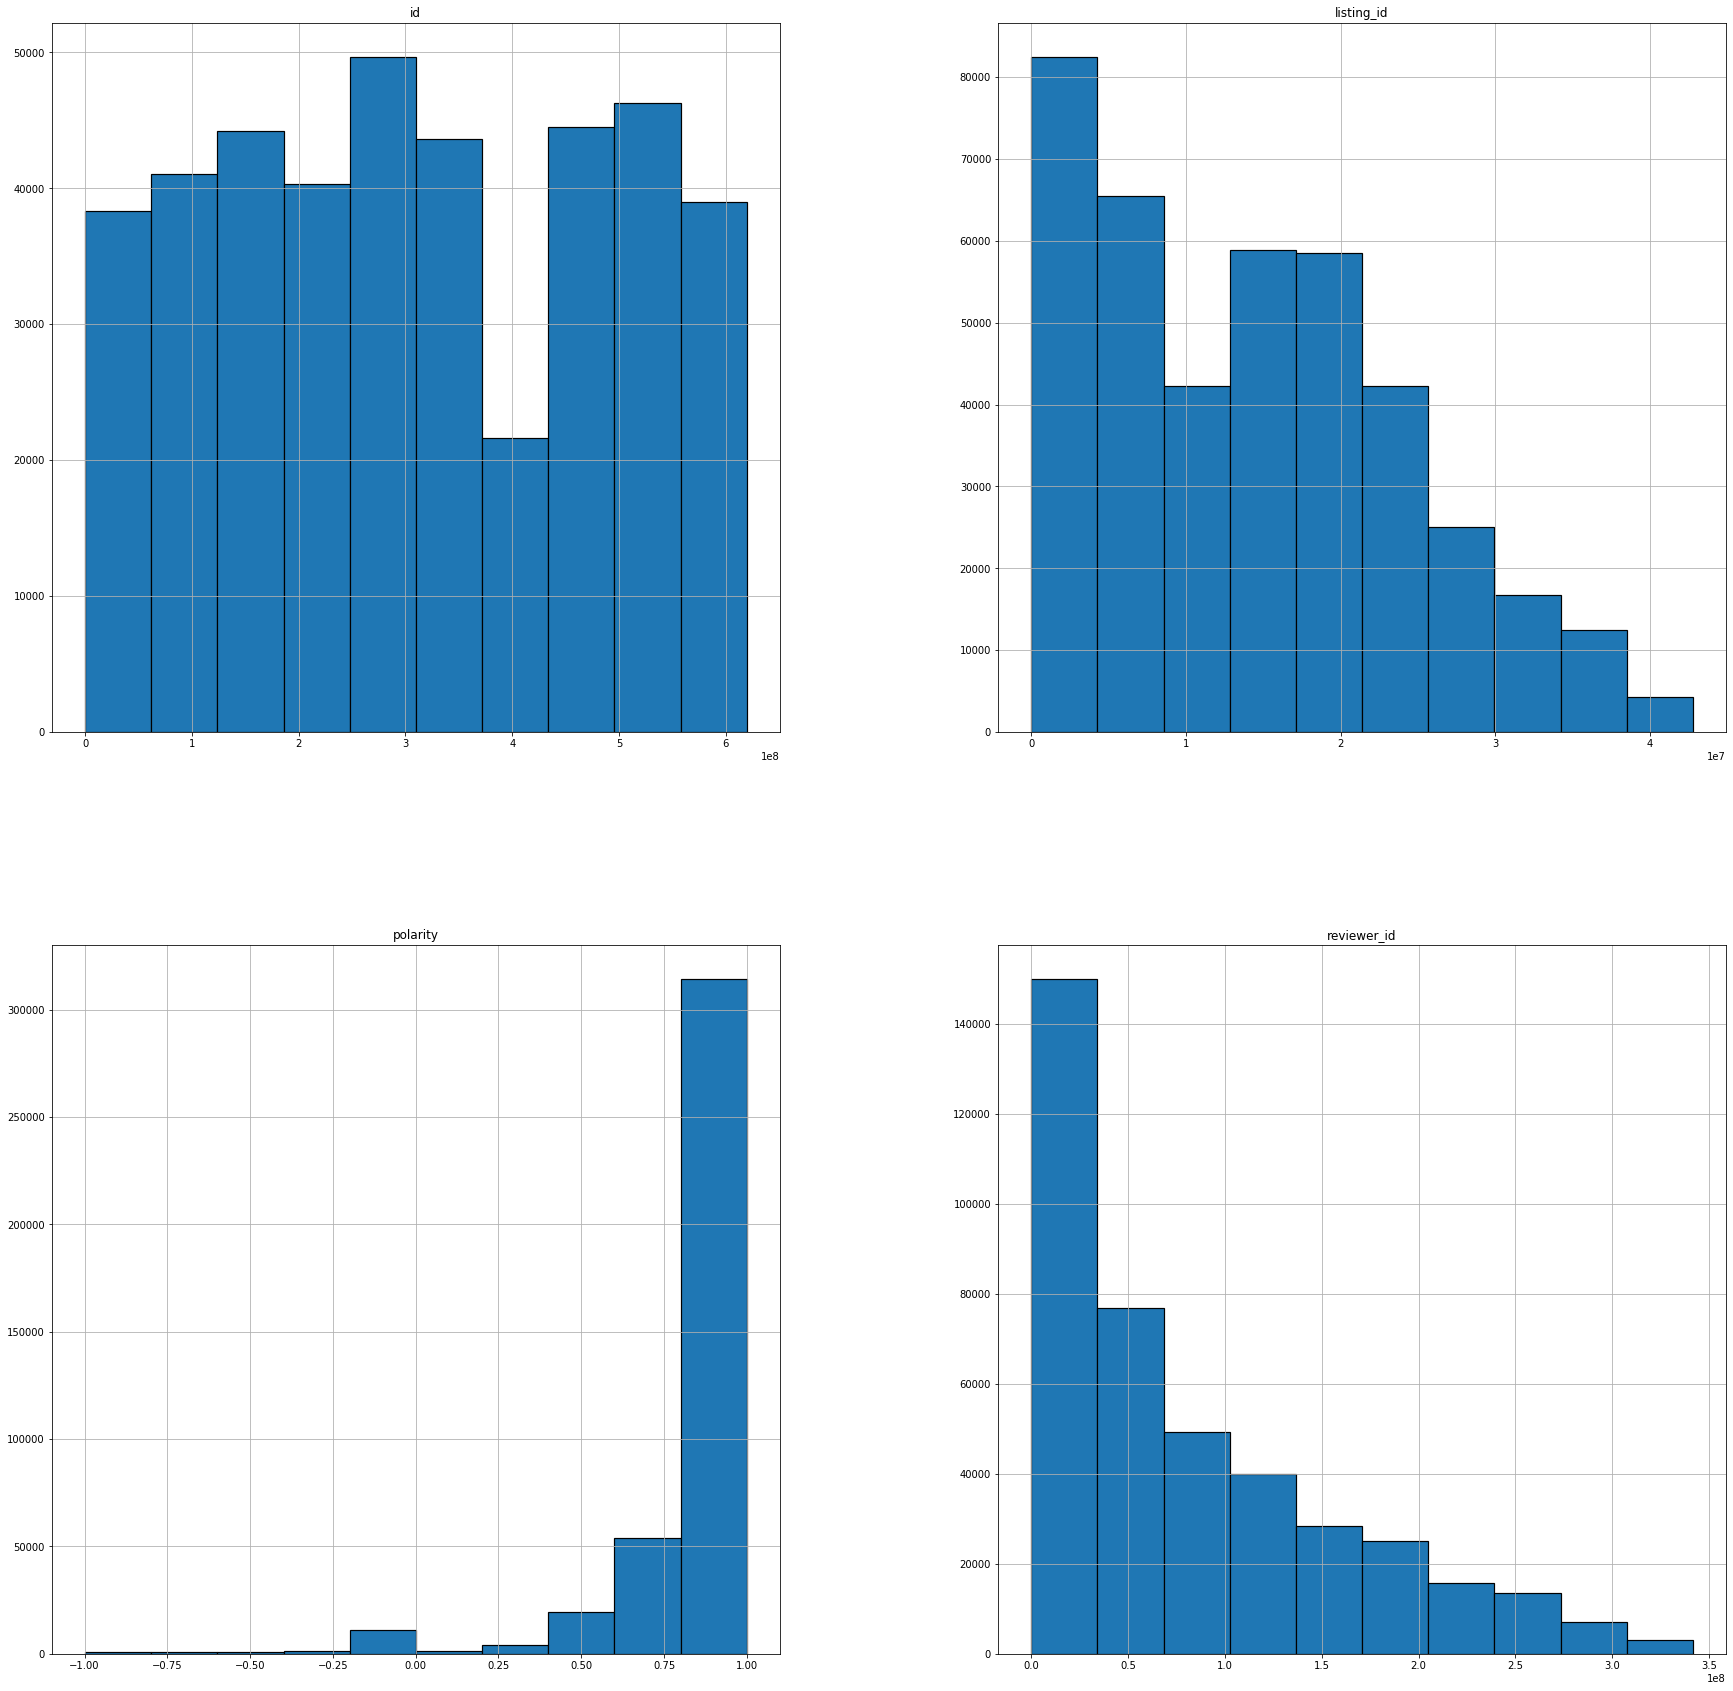

In [96]:
seattle_reviews.hist(edgecolor="black", linewidth=1.2, figsize=(30, 30));

Plotting the histogram of review intensities reveals the following peculiarities:
* huge asymmetry between positive and negative reviews, 80+ k of them (or almost 50%) are close to maximally positive (`polarity > 0.92`);
* prominent peak of ~10k 'neutral' reviews.

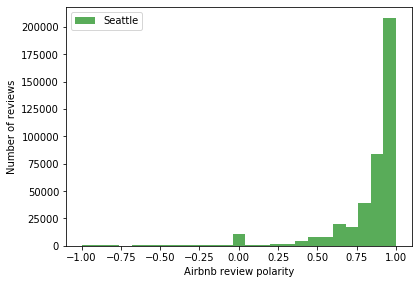

In [97]:
plt.hist(seattle_reviews.polarity, bins=25, color='g', alpha=0.65)
# plt.hist(copenhagen_reviews.polarity, bins=25, color='r', alpha=0.65)
# plt.hist(boston_reviews.polarity, bins=25, color='b', alpha=0.65)
# plt.legend(['Seattle', 'Copenhagen', 'Boston'])
plt.legend(['Seattle'])
plt.xlabel('Airbnb review polarity')
plt.ylabel('Number of reviews')
plt.subplots_adjust(left=0.15, right=0.95, top=0.95, bottom=0.12)

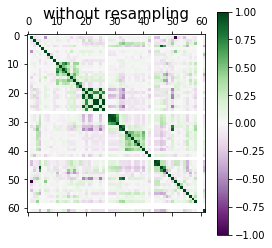

In [98]:
plt.matshow(seattle_listings.corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
plt.title('without resampling', size=15)
plt.colorbar()
plt.show()

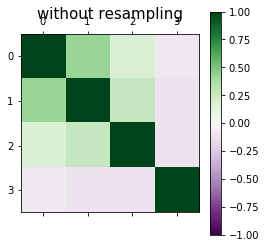

In [99]:
plt.matshow(seattle_reviews.corr(method='kendall'),vmax=1,vmin=-1,cmap='PRGn')
plt.title('without resampling', size=15)
plt.colorbar()
plt.show()

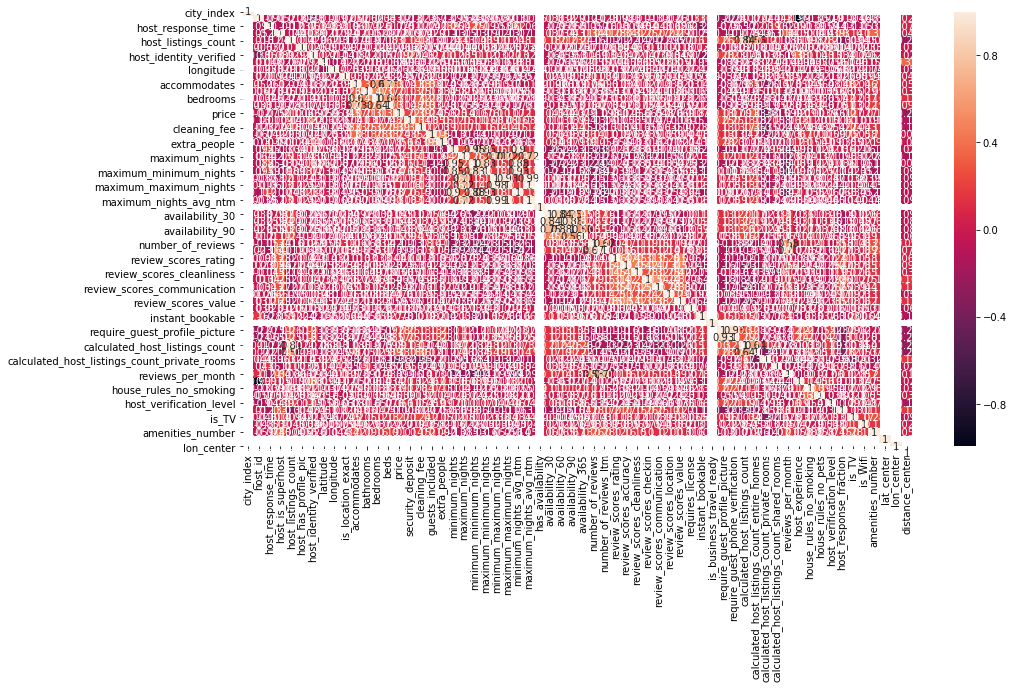

In [100]:
corr = seattle_listings.corr(method='kendall')
plt.figure(figsize=(15,8))
sns.heatmap(corr, annot=True)

<Figure size 2160x2160 with 0 Axes>

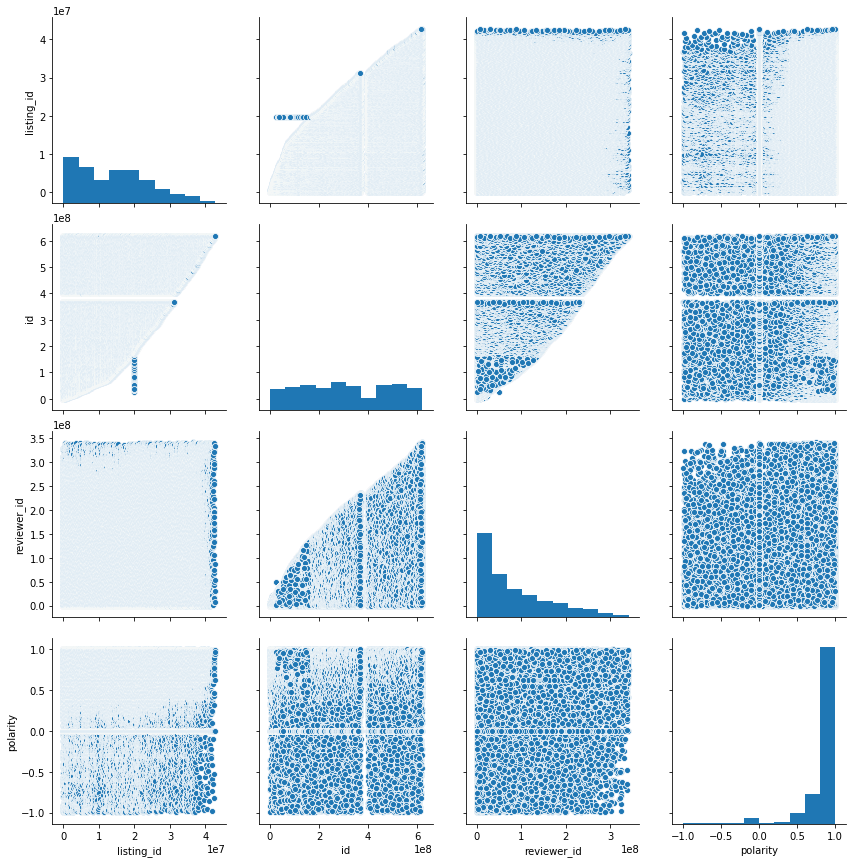

In [101]:
plt.figure(figsize=(30, 30))
sns.pairplot(seattle_reviews, height=3, diag_kind="hist")

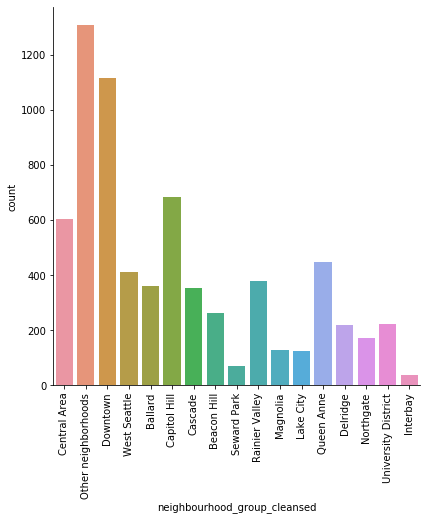

In [102]:
sns.catplot("neighbourhood_group_cleansed", data=seattle_listings, kind="count", height=6).set_xticklabels(rotation=90)

Plot all Neighbourhood Group

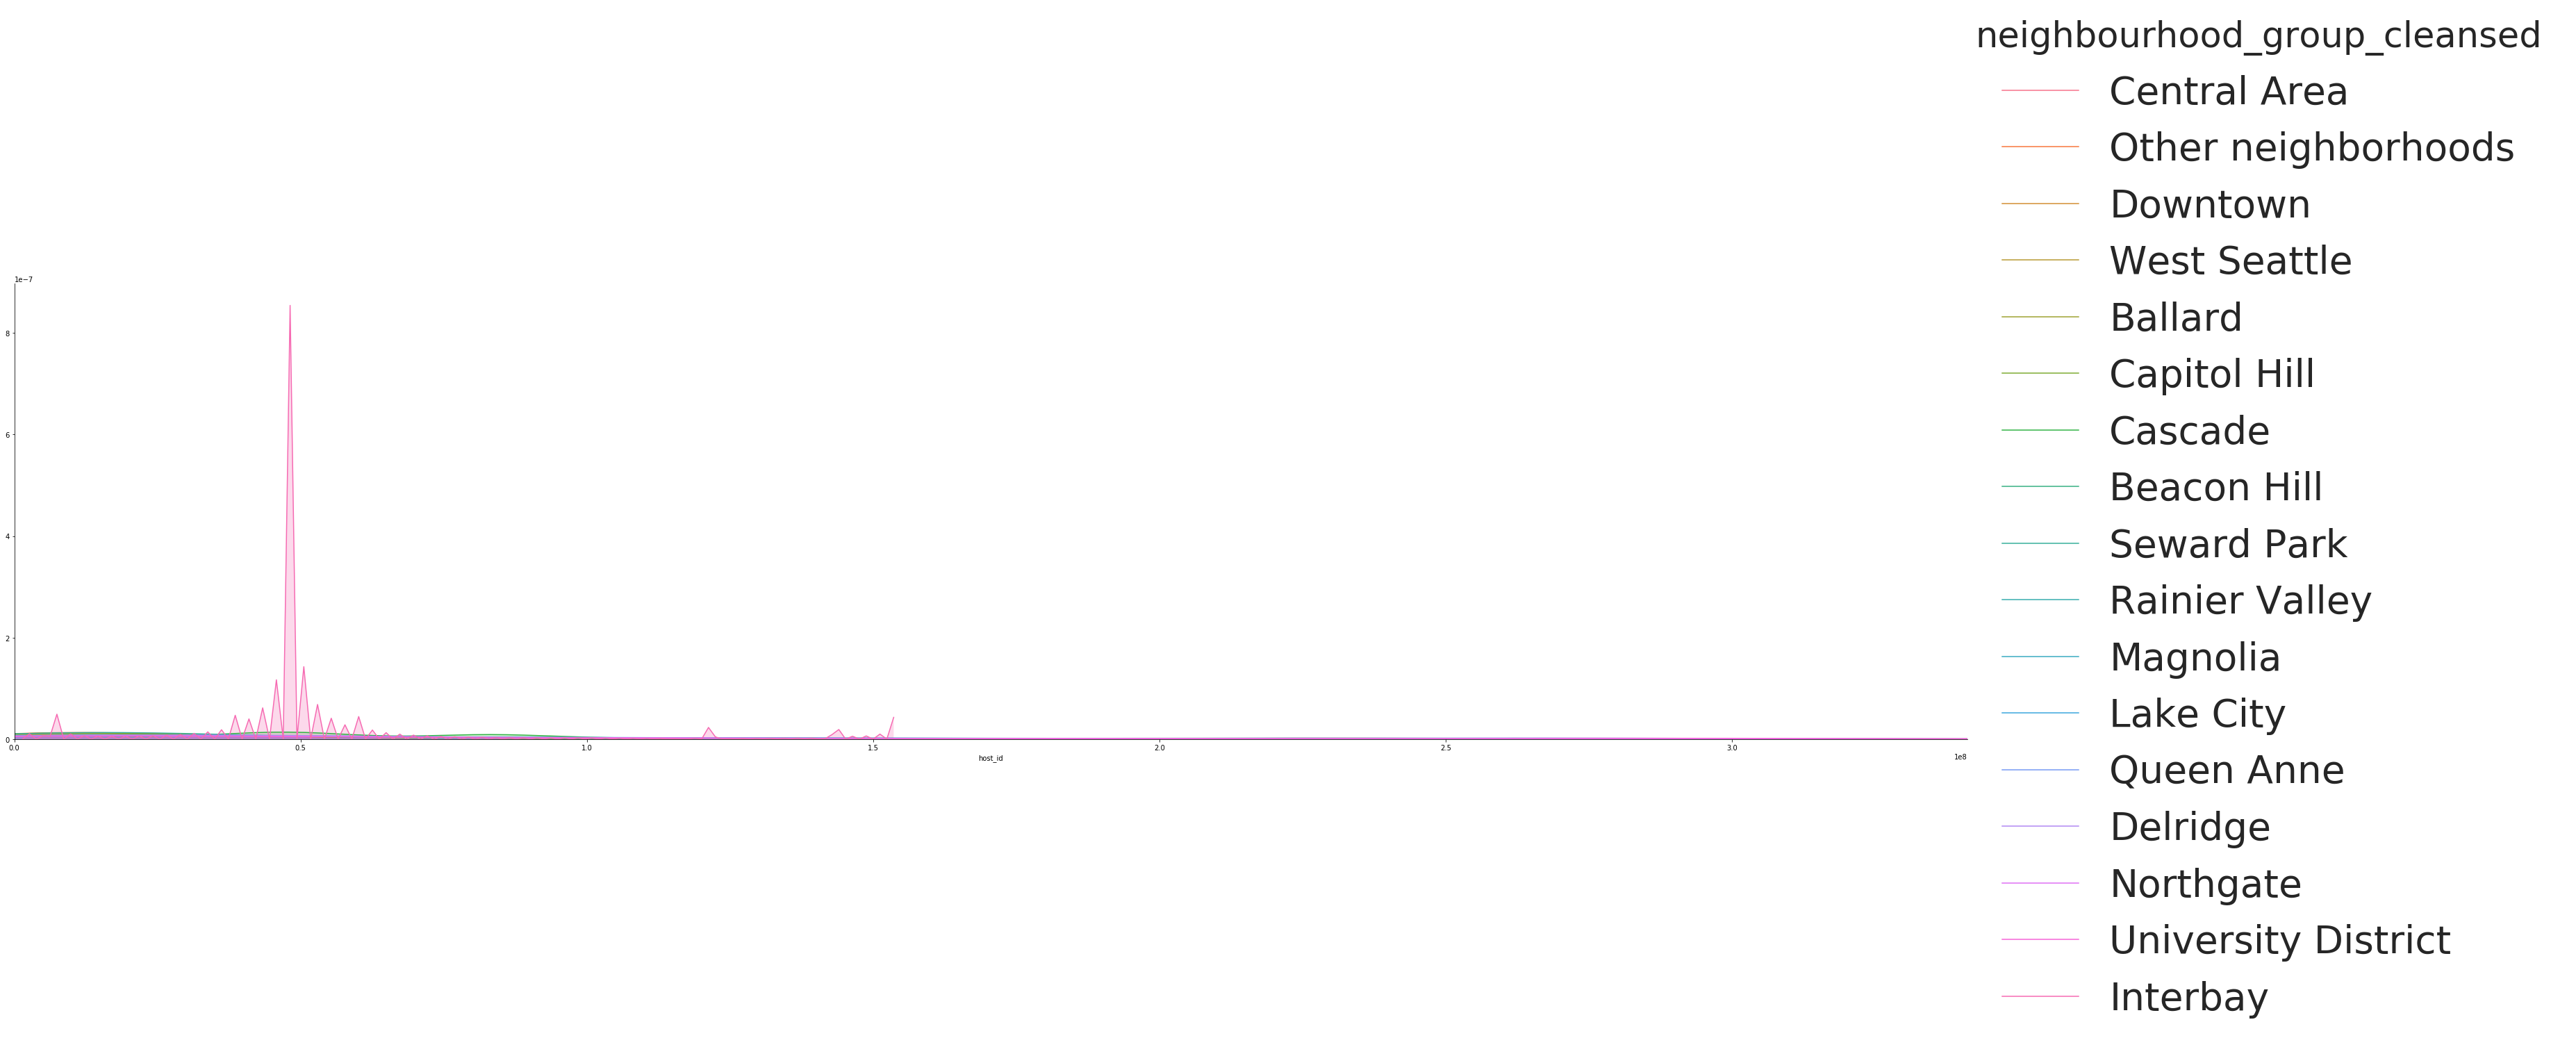

In [103]:
# Another way to visualize the data is to use FacetGrid to plot multiple kedplots on one plot

fig = sns.FacetGrid(seattle_listings, hue="neighbourhood_group_cleansed", aspect=4, height=10)
fig.map(sns.kdeplot, 'host_id', shade=True)
oldest = seattle_listings['host_id'].max()
fig.set(xlim=(0, oldest))
sns.set(font_scale=5)
fig.add_legend()

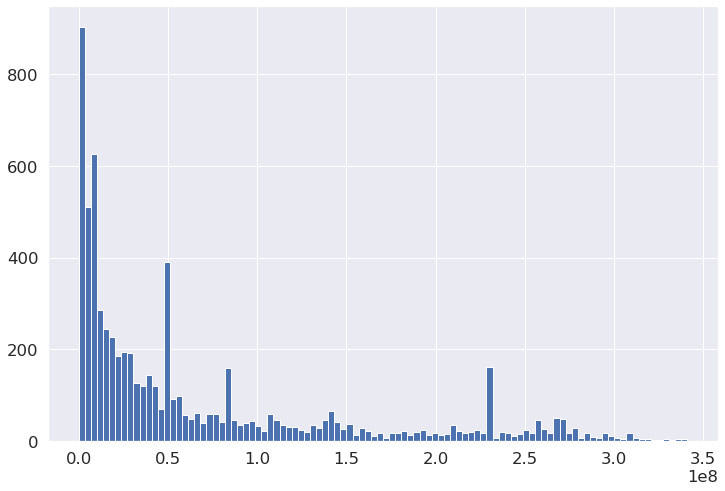

In [104]:
sns.set(font_scale=1.5)
plt.figure(figsize=(12, 8))
seattle_listings.host_id.hist(bins=100)

<BarContainer object of 10 artists>

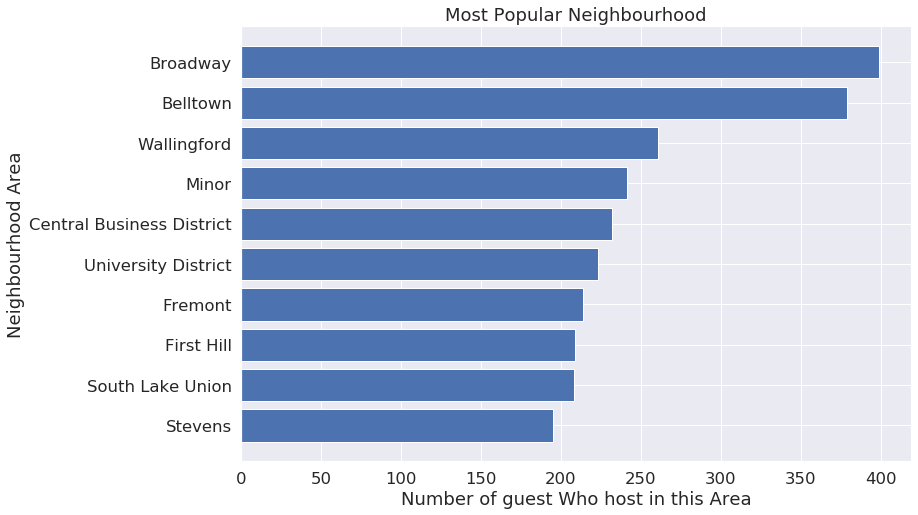

In [105]:
data = seattle_listings.neighbourhood_cleansed.value_counts()[:10]
plt.figure(figsize=(12, 8))
x = list(data.index)
y = list(data.values)
x.reverse()
y.reverse()

plt.title("Most Popular Neighbourhood")
plt.ylabel("Neighbourhood Area")
plt.xlabel("Number of guest Who host in this Area")

plt.barh(x, y)

Map of Neighbourhood group

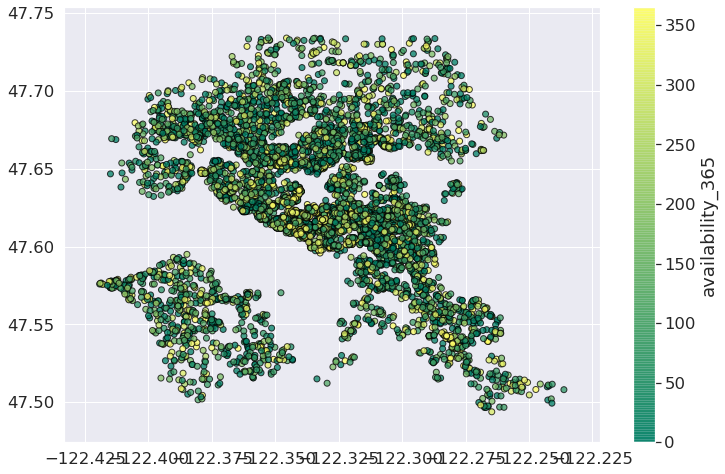

In [106]:
plt.figure(figsize=(12, 8))
plt.scatter(seattle_listings.longitude, seattle_listings.latitude, c=seattle_listings.availability_365, cmap='summer', edgecolor='black', linewidth=1, alpha=0.75)

cbar = plt.colorbar()
cbar.set_label('availability_365')

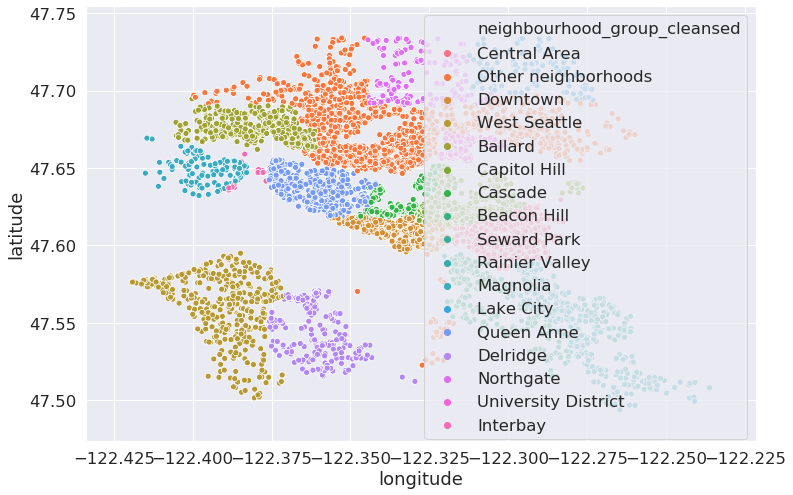

In [107]:
plt.figure(figsize=(12,8))
sns.scatterplot(seattle_listings.longitude,seattle_listings.latitude,hue=seattle_listings.neighbourhood_group_cleansed)
plt.ioff()
# cbar = plt.colorbar()
# cbar.set_label('Price $')

Map of Availability_365

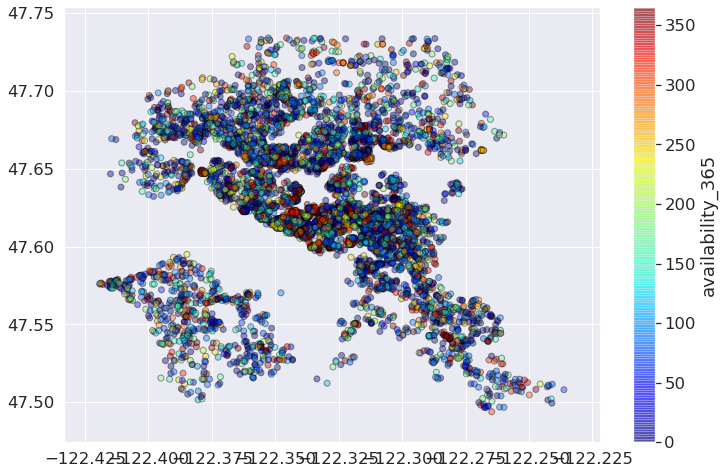

In [108]:
plt.figure(figsize=(12, 8))
plt.scatter(seattle_listings.longitude, seattle_listings.latitude, c=seattle_listings.availability_365, cmap=plt.get_cmap('jet'), alpha=0.4, edgecolor='black', linewidth=1)

cbar = plt.colorbar()
cbar.set_label('availability_365')


In [109]:
print(f"Average of price per night : ${seattle_listings.price.mean():.2f}")
print(f"Maximum price per night : ${seattle_listings.price.max()}")
print(f"Minimum price per night : ${seattle_listings.price.min()}")

Average of price per night : $129.54
Maximum price per night : $349.0
Minimum price per night : $27.0


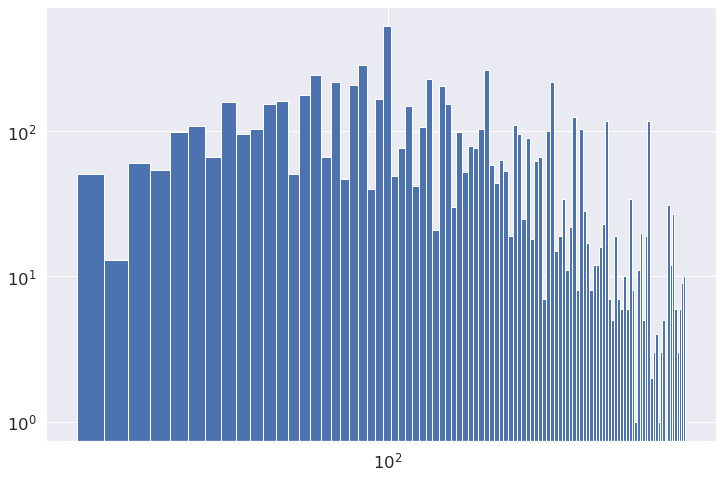

In [110]:
plt.figure(figsize=(12, 8))
plt.xscale('log')
plt.yscale('log')

seattle_listings.price.hist(bins=100)

Relation between neighbourgroup and Availability of Room

[Text(0, 0, 'Central Area'),
 Text(0, 0, 'Other neighborhoods'),
 Text(0, 0, 'Downtown'),
 Text(0, 0, 'West Seattle'),
 Text(0, 0, 'Ballard'),
 Text(0, 0, 'Capitol Hill'),
 Text(0, 0, 'Cascade'),
 Text(0, 0, 'Beacon Hill'),
 Text(0, 0, 'Seward Park'),
 Text(0, 0, 'Rainier Valley'),
 Text(0, 0, 'Magnolia'),
 Text(0, 0, 'Lake City'),
 Text(0, 0, 'Queen Anne'),
 Text(0, 0, 'Delridge'),
 Text(0, 0, 'Northgate'),
 Text(0, 0, 'University District'),
 Text(0, 0, 'Interbay')]

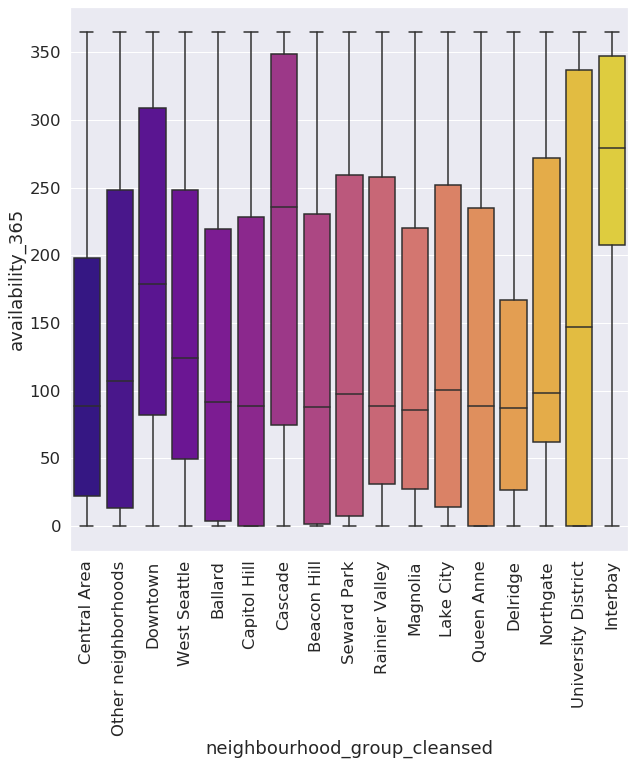

In [111]:
plt.figure(figsize=(10,10))
ax = sns.boxplot(data=seattle_listings, x='neighbourhood_group_cleansed',y='availability_365',palette='plasma')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

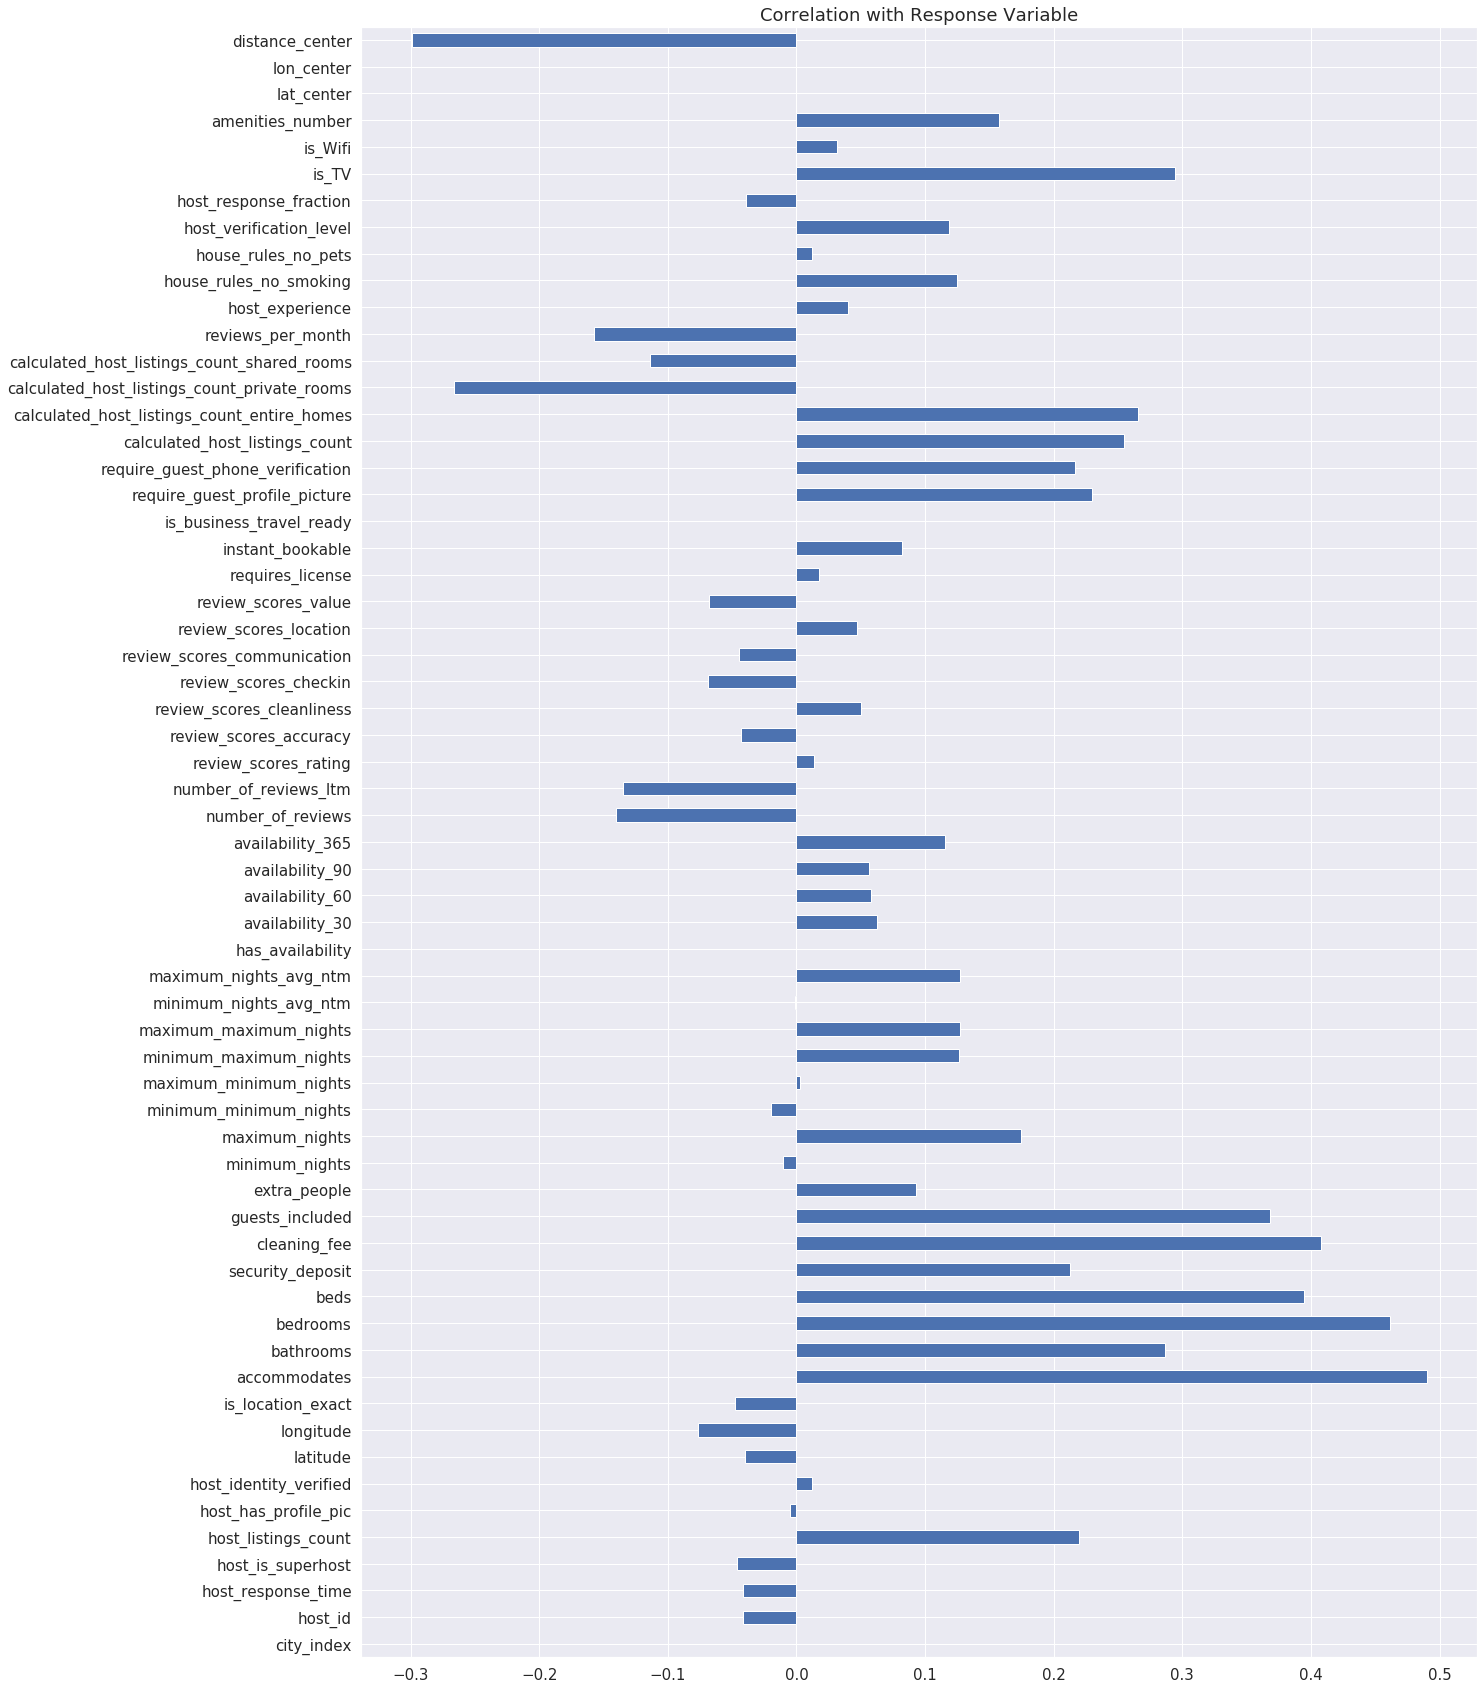

In [112]:
seattle_listings.drop('price', axis=1).corrwith(seattle_listings.price).plot.barh(figsize=(20, 30), 
                                                        title='Correlation with Response Variable',
                                                        fontsize=15, grid=True)

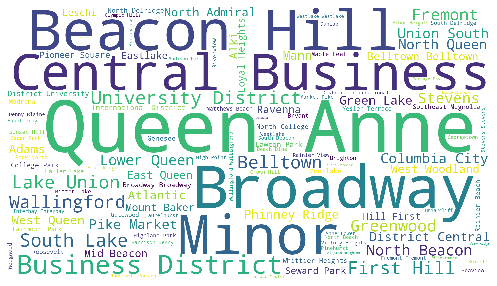

In [113]:
plt.subplots(figsize=(10,5))
wordcloud = WordCloud(
                          background_color='white',
                          width=1920,
                          height=1080
                         ).generate(" ".join(seattle_listings.neighbourhood_cleansed))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [114]:
(seattle_reviews.polarity.values < -0.8).mean()

0.002537332057734703

In [115]:
def show_most_common_duplicates(df, top_number=3):
    res = list(Counter(df.polarity.values).most_common(top_number))
    val_freq_list = [(i[0], i[1]/df.shape[0]) for i in res]
    return val_freq_list 

show_most_common_duplicates(seattle_reviews)

[(0.0, 0.02517757654203481),
 (0.6249, 0.016024096090746936),
 (0.6588, 0.012189959799068747)]

Other comments made in English, such as `'The host canceled ...'` or `'The reservation was canceled ...'`, are probably automatic messages generated by the system.

In [116]:
def zero_technical_reviews(df):
    res1 = df[df.polarity == 0.0].comments.map(lambda s: s.startswith('The host canceled')).sum()
    res2 = df[df.polarity == 0.0].comments.map(lambda s: s.startswith('The reservation was canceled')).sum()
    zero_polarity_fraction = (res1+res2)/df.shape[0]
    return zero_polarity_fraction

zero_technical_reviews(seattle_reviews)

0.003978497517720952

As we see, **the technical messages fraction about apartment cancellation in Copenhagen 4-6 times larger than in Boston and Seattle**!

Note also that although most of such technical messages are identified with score `0.0`, some of them are not:

In [117]:
def nonzero_technical_reviews(df):
    '''
    Returns the fraction of "technical" reviews (staring from "The host canceled" or
    "The reservation was canceled") of non-zero polarity
    
    Args:
        df (pandas dataframe): dataframe that contacts columns ['comments'] and ['polarity']
    
    Returns:
        nonzero_polarity_fraction (float): fraction of "technical" reviews of zero polarity
    '''
    
    res1 = df[df.polarity != 0.0].comments.map(lambda s: s.startswith('The host canceled')).sum()
    res2 = df[df.polarity != 0.0].comments.map(lambda s: s.startswith('The reservation was canceled')).sum()
    nonzero_polarity_fraction = (res1+res2)/df.shape[0]
    
    return nonzero_polarity_fraction
    
    
nonzero_technical_reviews(seattle_reviews)

1.7127603089819597e-05

In [118]:
seattle_reviews[seattle_reviews.polarity == 0.0].loc[:,:]

listing_id         id        date  reviewer_id  reviewer_name                                           comments  polarity
120           6606  161385220  2017-06-17     16489107         Fatima  Primera vez en Seattle, agradable estancia de ...       0.0
163           6606  334664615  2018-10-09     53318194          Brian  Everything was precisely as described and pict...       0.0
169           6606  468982516  2019-06-13    106214582  Sandra & Jack  Salle de bain et cuisine très très exigu le li...       0.0
221           9419    1424473  2012-06-05      2412668          Laura  The reservation was canceled 3 days before arr...       0.0
343           9460     127368  2010-10-25       243579          Gerry  The host canceled my reservation 3 days before...       0.0
...            ...        ...         ...          ...            ...                                                ...       ...
408803    42138876  604205621  2020-02-10    208320875            Ben  The host canceled this reservation 38 days bef...       0.0
408819    42180043  614068948  2020-03-03    123231811       Jennifer  cozy hidden gem with artsy touches, just minut...       0.0
408857    42364953  613793846  2020-03-02    301274882             谷口     とてもいいお家で素敵な方が出迎えてくれました!ぜひまたｼｱﾄﾙに行ったときは利用したいです!       0.0
408878    42518653  616444148  2020-03-09    297388309            Lee  The host canceled this reservation 2 days befo...       0.0
408882    42671642  616547142  2020-03-09     87799751        Juddson  The host canceled this reservation 45 days bef...       0.0

[10290 rows x 7 columns]

# What are the main factors that influence Airbnb renting price?

In [159]:
seattle_listings.fillna(seattle_listings.mean(), inplace=True)
y = seattle_listings['price']
X = seattle_listings.drop(['host_verifications','neighbourhood_group_cleansed'
                           ,'neighbourhood_cleansed','price', 'lat_center', 'lon_center', 'longitude',
                           'latitude', 'city_index'], axis=1) 
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

In [141]:
regr = GradientBoostingRegressor(random_state=42)
param_dist = {"max_depth": stats.randint(2, 6),
              "n_estimators": stats.randint(50, 200)}
#               "learning_rate": Real(10**-1, 10**0, "log-uniform", name='learning_rate'),
#              "subsample": stats.uniform(0.5, 0.5)}

n_iter_search = 50
random_search = RandomizedSearchCV(regr, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=3, verbose=2)

random_search.fit(X, y)
print(random_search.best_score_, random_search.best_estimator_)
print(r2_score(y_val, random_search.predict(X_val)))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] max_depth=3, n_estimators=61 ....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ..................... max_depth=3, n_estimators=61, total=   0.6s
[CV] max_depth=3, n_estimators=61 ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] ..................... max_depth=3, n_estimators=61, total=   0.6s
[CV] max_depth=3, n_estimators=61 ....................................
[CV] ..................... max_depth=3, n_estimators=61, total=   0.6s
[CV] max_depth=3, n_estimators=165 ...................................
[CV] .................... max_depth=3, n_estimators=165, total=   1.4s
[CV] max_depth=3, n_estimators=165 ...................................
[CV] .................... max_depth=3, n_estimators=165, total=   1.5s
[CV] max_depth=3, n_estimators=165 ...................................
[CV] .................... max_depth=3, n_estimators=165, total=   1.4s
[CV] max_depth=4, n_estimators=188 ...................................
[CV] .................... max_depth=4, n_estimators=188, total=   2.4s
[CV] max_depth=4, n_estimators=188 ...................................
[CV] .................... max_depth=4, n_estimators=188, total=   2.4s
[CV] max_depth=4, n_estimators=188 ...................................
[CV] .

[CV] .................... max_depth=3, n_estimators=127, total=   1.1s
[CV] max_depth=3, n_estimators=82 ....................................
[CV] ..................... max_depth=3, n_estimators=82, total=   0.7s
[CV] max_depth=3, n_estimators=82 ....................................
[CV] ..................... max_depth=3, n_estimators=82, total=   0.7s
[CV] max_depth=3, n_estimators=82 ....................................
[CV] ..................... max_depth=3, n_estimators=82, total=   0.7s
[CV] max_depth=5, n_estimators=163 ...................................
[CV] .................... max_depth=5, n_estimators=163, total=   2.8s
[CV] max_depth=5, n_estimators=163 ...................................
[CV] .................... max_depth=5, n_estimators=163, total=   2.8s
[CV] max_depth=5, n_estimators=163 ...................................
[CV] .................... max_depth=5, n_estimators=163, total=   2.9s
[CV] max_depth=2, n_estimators=99 ....................................
[CV] .

[CV] ..................... max_depth=2, n_estimators=83, total=   0.4s
[CV] max_depth=2, n_estimators=83 ....................................
[CV] ..................... max_depth=2, n_estimators=83, total=   0.4s
[CV] max_depth=2, n_estimators=83 ....................................
[CV] ..................... max_depth=2, n_estimators=83, total=   0.4s
[CV] max_depth=5, n_estimators=125 ...................................
[CV] .................... max_depth=5, n_estimators=125, total=   2.2s
[CV] max_depth=5, n_estimators=125 ...................................
[CV] .................... max_depth=5, n_estimators=125, total=   2.2s
[CV] max_depth=5, n_estimators=125 ...................................
[CV] .................... max_depth=5, n_estimators=125, total=   2.2s
[CV] max_depth=3, n_estimators=151 ...................................
[CV] .................... max_depth=3, n_estimators=151, total=   1.2s
[CV] max_depth=3, n_estimators=151 ...................................
[CV] .

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  3.4min finished


0.5648899319632666 GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=129,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


In [142]:
%%time 
regr = GradientBoostingRegressor(n_estimators=75, learning_rate=0.31, max_depth=4, subsample=1.0,
                                 random_state=42)
regr.fit(X_train, y_train)
print(r2_score(y_val, regr.predict(X_val)))

0.6284907846557455
CPU times: user 1.1 s, sys: 0 ns, total: 1.1 s
Wall time: 1.1 s


In [153]:
import eli5
perm1 = PermutationImportance(random_search, random_state=42).fit(X_val, y_val)
eli5.show_weights(perm1, top=X_train.shape[1], feature_names = X_train.columns.tolist())

As we see, `distance_center` are among the most important features for price prediction in seattle, as expected.
Thus removing all the features which have weights less than 0.01

In [167]:
seattle_reviews = pd.read_hdf('../input/cleaned_seattle_reviews.h5', 'seattle_reviews')
seattle_listings = pd.read_hdf('../input/cleaned_seattle_listings.h5', 'seattle_listings')

In [165]:
less_imp_features = ['maximum_nights',
                     'minimum_maximum_nights',
                     'availability_90',
                     'host_verification_level',
                     'minimum_nights_avg_ntm',
                     'maximum_nights_avg_ntm',
                     'minimum_minimum_nights',
                     'calculated_host_listings_count_shared_rooms',
                     'review_scores_cleanliness',
                     'is_TV',
                     'review_scores_location',
                     'host_response_time',
                     'house_rules_no_pets',
                     'availability_60',
                     'maximum_minimum_nights',
                     'house_rules_no_smoking',
                     'availability_30',
                     'minimum_nights',
                     'host_is_superhost',
                     'is_location_exact',
                     'instant_bookable',
                     'maximum_maximum_nights',
                     'review_scores_communication',
                     'review_scores_checkin',
                     'require_guest_profile_picture',
                     'host_identity_verified',
                     'review_scores_accuracy',
                     'require_guest_phone_verification',
                     'is_Wifi',
                     'host_has_profile_pic',
                     'is_business_travel_ready',
                     'requires_license',
                     'has_availability'
                    ]

seattle_listings.drop(less_imp_features, axis=1, inplace=True)
seattle_listings.head()

city_index  host_id host_acceptance_rate  host_listings_count                                 host_verifications neighbourhood_cleansed neighbourhood_group_cleansed  latitude  longitude  room_type  accommodates  bathrooms  bedrooms  beds  price  security_deposit  cleaning_fee  guests_included  extra_people  availability_365  number_of_reviews  number_of_reviews_ltm  review_scores_rating  review_scores_value  calculated_host_listings_count  calculated_host_listings_count_entire_homes  calculated_host_listings_count_private_rooms  reviews_per_month  host_experience  host_response_fraction  amenities_number  lat_center  lon_center  distance_center
0           1     2536                  91%                    2  ['email', 'phone', 'reviews', 'jumio', 'offlin...                Madrona                 Central Area  47.61082 -122.29082          3             9        2.5       4.0   4.0  296.0             500.0         250.0                8          25.0                86                 32                     10                 100.0                 10.0                               2                                            2                                             0               0.23             4221                    1.00                39    47.60621  -122.33207         3.143579
1           1    14942                  94%                    5   ['email', 'phone', 'facebook', 'reviews', 'kba']            Wallingford          Other neighborhoods  47.65411 -122.33761          3             2        1.0       1.0   1.0   90.0             200.0          40.0                2          10.0                45                150                     15                  92.0                  9.0                               3                                            3                                             0               1.15             3979                    0.90                21    47.60621  -122.33207         5.341923
2           1    30559                  92%                    8  ['email', 'phone', 'reviews', 'jumio', 'offlin...             Georgetown          Other neighborhoods  47.55017 -122.31937          2             2        3.0       1.0   1.0   62.0             100.0          20.0                1          15.0               365                148                     16                  93.0                 10.0                               8                                            0                                             8               1.26             3874                    0.96                34    47.60621  -122.33207         6.303476
3           1    30832                 100%                    4  ['email', 'phone', 'reviews', 'offline_governm...             First Hill                     Downtown  47.61265 -122.32936          2             2        1.0       1.0   1.0   79.0               0.0          45.0                1          15.0                10                466                     53                  98.0                  9.0                               4                                            3                                             1               3.63             3873                    1.00                48    47.60621  -122.33207         0.744444
4           1    31481                  80%                    2               ['email', 'phone', 'reviews', 'kba']         Fairmount Park                 West Seattle  47.55539 -122.38474          3             4        1.0       2.0   3.0  165.0             300.0         120.0                2          10.0               276                 40                      4                 100.0                 10.0                               2                                            2                                             0               0.40             3870                    1.00                50    47.60621  -122.33207         6.901093

In [172]:
seattle_listings.to_hdf('../input/cleaned_seattle_listings.h5', key='seattle_listings', mode='w')

In [173]:
seattle_listings.head()

city_index  host_id  host_listings_count                                 host_verifications neighbourhood_cleansed neighbourhood_group_cleansed  latitude  longitude  room_type  accommodates  bathrooms  bedrooms  beds  price  security_deposit  cleaning_fee  guests_included  extra_people  availability_365  number_of_reviews  number_of_reviews_ltm  review_scores_rating  review_scores_value  calculated_host_listings_count  calculated_host_listings_count_entire_homes  calculated_host_listings_count_private_rooms  reviews_per_month  host_experience  host_response_fraction  amenities_number  lat_center  lon_center  distance_center  host_acceptance_fraction
0           1     2536                    2  ['email', 'phone', 'reviews', 'jumio', 'offlin...                Madrona                 Central Area  47.61082 -122.29082          3             9        2.5       4.0   4.0  296.0             500.0         250.0                8          25.0                86                 32                     10                 100.0                 10.0                               2                                            2                                             0               0.23             4221                    1.00                39    47.60621  -122.33207         3.143579                      0.91
1           1    14942                    5   ['email', 'phone', 'facebook', 'reviews', 'kba']            Wallingford          Other neighborhoods  47.65411 -122.33761          3             2        1.0       1.0   1.0   90.0             200.0          40.0                2          10.0                45                150                     15                  92.0                  9.0                               3                                            3                                             0               1.15             3979                    0.90                21    47.60621  -122.33207         5.341923                      0.94
2           1    30559                    8  ['email', 'phone', 'reviews', 'jumio', 'offlin...             Georgetown          Other neighborhoods  47.55017 -122.31937          2             2        3.0       1.0   1.0   62.0             100.0          20.0                1          15.0               365                148                     16                  93.0                 10.0                               8                                            0                                             8               1.26             3874                    0.96                34    47.60621  -122.33207         6.303476                      0.92
3           1    30832                    4  ['email', 'phone', 'reviews', 'offline_governm...             First Hill                     Downtown  47.61265 -122.32936          2             2        1.0       1.0   1.0   79.0               0.0          45.0                1          15.0                10                466                     53                  98.0                  9.0                               4                                            3                                             1               3.63             3873                    1.00                48    47.60621  -122.33207         0.744444                      1.00
4           1    31481                    2               ['email', 'phone', 'reviews', 'kba']         Fairmount Park                 West Seattle  47.55539 -122.38474          3             4        1.0       2.0   3.0  165.0             300.0         120.0                2          10.0               276                 40                      4                 100.0                 10.0                               2                                            2                                             0               0.40             3870                    1.00                50    47.60621  -122.33207         6.901093                      0.80